**Tesla Stock Price Prediction**

Aahil Jivani (8729441)

Alex Rodriguez (300452235)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
file_name = 'tsla_2018_2025.csv' # adjust if necessary
df = pd.read_csv(file_name)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1761 non-null   object 
 1   close          1761 non-null   float64
 2   high           1761 non-null   float64
 3   low            1761 non-null   float64
 4   open           1761 non-null   float64
 5   volume         1761 non-null   int64  
 6   rsi_14         1747 non-null   float64
 7   rsi_7          1754 non-null   float64
 8   MACD_12_26_9   1736 non-null   float64
 9   MACDh_12_26_9  1728 non-null   float64
 10  MACDs_12_26_9  1728 non-null   float64
 11  sma_10         1752 non-null   float64
 12  sma_20         1742 non-null   float64
 13  sma_50         1712 non-null   float64
 14  sma_100        1662 non-null   float64
 15  sma_200        1562 non-null   float64
 16  ema_10         1752 non-null   float64
 17  ema_20         1742 non-null   float64
 18  ema_50  

# 1 Data Preprocessing

## 1.2 Data Cleaning

## 1.3 Feature Engineering

In [ ]:
# Volume-Weighted Average Price (VWAP) - 1, 3, 5, 10 days

# Calculate Typical Price
df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3

# Calculate VWAP for each period
for period in [1, 3, 5, 10]:
    df[f'VWAP_{period}_day'] = df['typical_price'].rolling(window=period).apply(
        lambda x: (x * df.loc[x.index, 'volume']).sum() / df.loc[x.index, 'volume'].sum(), raw=False
    )

In [ ]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Assigning Quarter value
df['quarter'] = df['date'].dt.quarter

In [ ]:
# Days till next Quarter

# Calculate days until next quarter
def days_to_next_quarter(Date, Quarter):
    next_quarter_start = {
        1: pd.Timestamp(year=Date.year, month=4, day=1),
        2: pd.Timestamp(year=Date.year, month=7, day=1),
        3: pd.Timestamp(year=Date.year, month=10, day=1),
        4: pd.Timestamp(year=Date.year + 1, month=1, day=1),  # Next year's Q1
    }[Quarter]

    return (next_quarter_start - Date).days

# Apply function to compute days until next quarter
df['Next_Quarter_Start_(days)'] = df.apply(lambda row: days_to_next_quarter(row['date'], row['quarter']), axis=1)

In [ ]:
# Next day open
df['tomorrow_open'] = df['open'].shift(-1)

### Target:

Rationale: Model will predict close price of the next day. Since a trade would be placed the next day when the market opens, technically, the model would have access to that open price. Therefore, the model uses all past data and the open price of the day ("tomorrow_open") to predict the close price of the day ("tomorrow_close").

A simple example trade algo could be: if predicted tomorrow_close > tomorrow_open then buy, else don't buy

In [ ]:
# Next day close (target)
df['tomorrow_close'] = df['close'].shift(-1)

In [ ]:
df.head()

,date,close,high,low,open,volume,rsi_14,rsi_7,MACD_12_26_9,MACDh_12_26_9,...,AROONOSC_14,typical_price,VWAP_1_day,VWAP_3_day,VWAP_5_day,VWAP_10_day,quarter,Next_Quarter_Start_(days),tomorrow_open,tomorrow_close
0,2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000,NaN,NaN,NaN,NaN,...,NaN,21.192001,21.192001,NaN,NaN,NaN,1,89,21.400000,21.150000
1,2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500,NaN,NaN,NaN,NaN,...,NaN,21.290000,21.290000,NaN,NaN,NaN,1,88,20.858000,20.974667
2,2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500,NaN,NaN,NaN,NaN,...,NaN,20.863334,20.863334,21.041846,NaN,NaN,1,87,21.108000,21.105333
3,2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000,NaN,NaN,NaN,NaN,...,NaN,21.018222,21.018222,21.001866,NaN,NaN,1,86,21.066668,22.427334
4,2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000,NaN,NaN,NaN,NaN,...,NaN,21.976222,21.976222,21.342228,21.315479,NaN,1,83,22.344000,22.246000


In [ ]:
df.tail()

,date,close,high,low,open,volume,rsi_14,rsi_7,MACD_12_26_9,MACDh_12_26_9,...,AROONOSC_14,typical_price,VWAP_1_day,VWAP_3_day,VWAP_5_day,VWAP_10_day,quarter,Next_Quarter_Start_(days),tomorrow_open,tomorrow_close
1756,2024-12-24,462.279999,462.779999,435.140015,435.899994,59551800,68.422829,67.654821,34.480358,-0.059537,...,71.428571,453.400004,453.400004,433.697270,439.652242,440.821223,4,8,465.160004,454.130005
1757,2024-12-26,454.130005,465.329987,451.019989,465.160004,76366400,65.645587,62.754328,34.011526,-0.422695,...,64.285714,456.826660,456.826660,445.398808,438.527844,444.382278,4,6,449.519989,431.660004
1758,2024-12-27,431.660004,450.000000,426.500000,449.519989,82666800,58.585163,50.896135,31.464133,-2.376070,...,57.142857,436.053335,436.053335,448.036817,438.327919,445.728532,4,5,419.399994,417.410004
1759,2024-12-30,417.410004,427.000000,415.750000,419.399994,64941000,54.576261,44.653237,27.972995,-4.693767,...,50.000000,420.053335,420.053335,438.497045,438.609484,445.513570,4,2,423.790009,403.839996
1760,2024-12-31,403.839996,427.929993,402.540009,423.790009,76825100,50.997470,39.297943,23.836484,-7.064222,...,42.857143,411.436666,411.436666,422.997165,435.190774,441.780853,4,1,NaN,NaN


## 1.1 Handling Missing Data

In [ ]:
# How many missing values do we have?
df.isnull().sum()

,0
date,0
close,0
high,0
low,0
open,0
volume,0
rsi_14,14
rsi_7,7
MACD_12_26_9,25
MACDh_12_26_9,33


In [ ]:
# Lets see which rows contain one or more missing values.
missing_rows = df[df.isnull().any(axis=1)]


missing_rows


,date,close,high,low,open,volume,rsi_14,rsi_7,MACD_12_26_9,MACDh_12_26_9,...,AROONOSC_14,typical_price,VWAP_1_day,VWAP_3_day,VWAP_5_day,VWAP_10_day,quarter,Next_Quarter_Start_(days),tomorrow_open,tomorrow_close
0,2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000,NaN,NaN,NaN,NaN,...,NaN,21.192001,21.192001,NaN,NaN,NaN,1,89,21.400000,21.150000
1,2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500,NaN,NaN,NaN,NaN,...,NaN,21.290000,21.290000,NaN,NaN,NaN,1,88,20.858000,20.974667
2,2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500,NaN,NaN,NaN,NaN,...,NaN,20.863334,20.863334,21.041846,NaN,NaN,1,87,21.108000,21.105333
3,2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000,NaN,NaN,NaN,NaN,...,NaN,21.018222,21.018222,21.001866,NaN,NaN,1,86,21.066668,22.427334
4,2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000,NaN,NaN,NaN,NaN,...,NaN,21.976222,21.976222,21.342228,21.315479,NaN,1,83,22.344000,22.246000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2018-10-10,17.125334,17.700666,16.518000,17.640667,192229500,39.371756,36.010035,-0.719649,-0.250053,...,-42.857143,17.114667,17.114667,17.181323,17.589156,18.584300,4,83,17.168667,16.815332
196,2018-10-11,16.815332,17.483334,16.601999,17.168667,122515500,38.166260,33.911372,-0.797068,-0.261977,...,-42.857143,16.966888,16.966888,17.181228,17.300582,18.378103,4,82,17.400000,17.252001
197,2018-10-12,17.252001,17.466000,16.800667,17.400000,108021000,40.910753,39.687800,-0.813807,-0.222973,...,-42.857143,17.172889,17.172889,17.086718,17.147588,18.451534,4,81,17.270666,17.306000
198,2018-10-15,17.306000,17.552000,16.969334,17.270666,93000000,41.257972,40.438863,-0.813339,-0.178004,...,-42.857143,17.275778,17.275778,17.124457,17.192557,17.965249,4,78,17.713333,18.439333


In [ ]:
# Missing rows are within the first 200 days of 2018 and the very end of 2024, which makes sense given the rolling average indicators. (ie. sma_200 and tomorrow_close respectively)

# Drop NA

df.dropna(inplace=True)
df.isnull().sum()

,0
date,0
close,0
high,0
low,0
open,0
volume,0
rsi_14,0
rsi_7,0
MACD_12_26_9,0
MACDh_12_26_9,0


## 1.4 Data Transformation

# 2 Exploratory Data Analysis

## 2.0 Feature Importance & Selection

In [ ]:
# Feature selection of indicators

# Define columns to exclude from candidate features
vital_features = ['date', 'open', 'high', 'low', 'close', 'volume', 'tomorrow_open',
                'tomorrow_close', 'typical_price', 'quarter', 'Next_Quarter_Start_(days)']

# Candidate features: all columns that are not in the exclude list
candidate_features = [col for col in df.columns if col not in vital_features]

print("Number of candidate features:", len(candidate_features))
print("Candidate features:")
print(candidate_features)

Number of candidate features: 36
Candidate features:
['rsi_14', 'rsi_7', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200', 'ema_10', 'ema_20', 'ema_50', 'ema_100', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'atr_14', 'cci_20', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'roc_10', 'ADX_14', 'DMP_14', 'DMN_14', 'obv', 'willr', 'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'VWAP_1_day', 'VWAP_3_day', 'VWAP_5_day', 'VWAP_10_day']


In [ ]:
# Prepare the data for feature selection
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the candidate features
scaled_features = scaler.fit_transform(df[candidate_features])
X_scaled = pd.DataFrame(scaled_features, columns=candidate_features)

# Our target variable remains unchanged
y = df['tomorrow_close']

Feature Importances (Training Data):
VWAP_1_day       0.921273
VWAP_3_day       0.017877
VWAP_5_day       0.010082
sma_200          0.006462
ema_50           0.005905
sma_50           0.005376
ema_100          0.005264
BBU_20_2.0       0.004076
sma_20           0.004035
obv              0.003903
ema_10           0.003582
sma_100          0.003078
sma_10           0.002005
BBM_20_2.0       0.001951
VWAP_10_day      0.001269
ema_20           0.000800
DMN_14           0.000279
ADX_14           0.000226
BBL_20_2.0       0.000218
DMP_14           0.000198
willr            0.000197
BBB_20_2.0       0.000193
atr_14           0.000188
MACD_12_26_9     0.000161
rsi_7            0.000154
MACDs_12_26_9    0.000147
STOCHd_14_3_3    0.000134
cci_20           0.000131
roc_10           0.000131
BBP_20_2.0       0.000124
MACDh_12_26_9    0.000116
AROONOSC_14      0.000100
rsi_14           0.000100
STOCHk_14_3_3    0.000094
AROOND_14        0.000087
AROONU_14        0.000085
dtype: float64

RandomFores

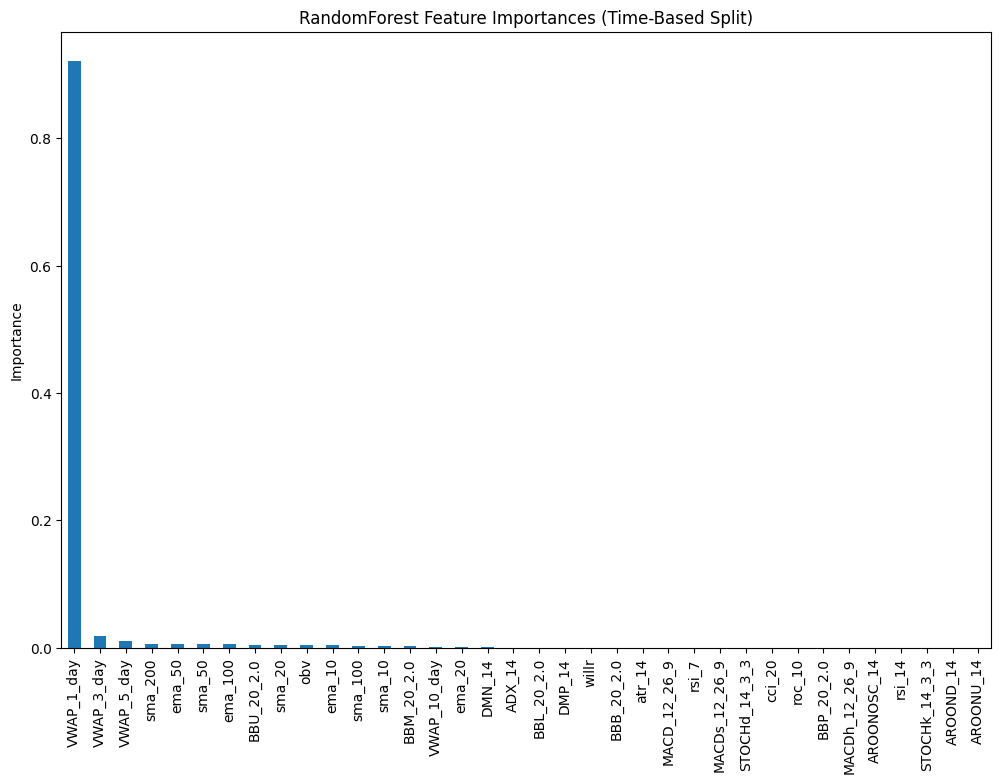

In [ ]:
# Run a Random Forest algorithm for Feature Importance

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Time-based train/test split (e.g., 80% for training, 20% for testing)
split_index = int(len(X_scaled) * 0.8)

X_train = X_scaled.iloc[:split_index]
X_test  = X_scaled.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# 2. Fit RandomForest on the training set only
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3. Extract feature importances from the trained model
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

print("Feature Importances (Training Data):")
print(feature_importance)

# 4. Evaluate the model on train and test sets (optional, but informative)
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"\nRandomForest R^2 on Training Data: {train_score:.3f}")
print(f"RandomForest R^2 on Testing Data:  {test_score:.3f}")

# 5. Plot feature importances
plt.figure(figsize=(12,8))
feature_importance.plot(kind='bar')
plt.title("RandomForest Feature Importances (Time-Based Split)")
plt.ylabel("Importance")
plt.show()

In [ ]:
# Compile the list of indicators that have feature importance ranking above 0.01
selected_features = [col for col, imp in feature_importance.items() if imp > 0.001]

print("Selected Features:", selected_features)

Selected Features: ['VWAP_1_day', 'VWAP_3_day', 'VWAP_5_day', 'sma_200', 'ema_50', 'sma_50', 'ema_100', 'BBU_20_2.0', 'sma_20', 'obv', 'ema_10', 'sma_100', 'sma_10', 'BBM_20_2.0', 'VWAP_10_day']


In [ ]:
df_final = pd.concat([df[vital_features], df[selected_features]], axis=1)

In [ ]:
df_final.head()

,date,open,high,low,close,volume,tomorrow_open,tomorrow_close,typical_price,quarter,...,sma_50,ema_100,BBU_20_2.0,sma_20,obv,ema_10,sma_100,sma_10,BBM_20_2.0,VWAP_10_day
199,2018-10-16,17.713333,18.492001,17.482668,18.439333,142896000,18.826668,18.118668,18.138000,4,...,20.077240,20.221286,21.638994,18.822400,-2.165222e+09,17.895505,20.757740,17.706734,18.822400,17.711551
200,2018-10-17,18.826668,18.846666,17.719999,18.118668,129832500,17.952667,17.594000,18.228444,4,...,19.933520,20.179650,21.515813,18.731600,-2.295054e+09,17.936080,20.753027,17.553267,18.731600,17.596134
201,2018-10-18,17.952667,18.066668,17.533333,17.594000,81318000,17.826000,17.333332,17.731333,4,...,19.791613,20.128449,21.389997,18.616867,-2.376372e+09,17.873884,20.739793,17.433800,18.616867,17.470793
202,2018-10-19,17.826000,17.977333,16.900000,17.333332,140632500,17.378668,17.396667,17.403555,4,...,19.668347,20.073100,21.243645,18.486533,-2.517004e+09,17.775602,20.718647,17.420800,18.486533,17.418316
203,2018-10-22,17.378668,17.457333,16.839333,17.396667,84004500,17.591333,19.609333,17.231111,4,...,19.542293,20.020102,21.064325,18.357433,-2.433000e+09,17.706705,20.702793,17.490067,18.357433,17.464101


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1561 entries, 199 to 1759
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1561 non-null   datetime64[ns]
 1   open                       1561 non-null   float64       
 2   high                       1561 non-null   float64       
 3   low                        1561 non-null   float64       
 4   close                      1561 non-null   float64       
 5   volume                     1561 non-null   int64         
 6   tomorrow_open              1561 non-null   float64       
 7   tomorrow_close             1561 non-null   float64       
 8   typical_price              1561 non-null   float64       
 9   quarter                    1561 non-null   int32         
 10  Next_Quarter_Start_(days)  1561 non-null   int64         
 11  VWAP_1_day                 1561 non-null   float64       
 12  VWAP_3_da

## 2.1 Summary Statistics

In [ ]:
numeric_columns = df_final.select_dtypes(include='number')

In [ ]:
numeric_columns.describe()

,open,high,low,close,volume,tomorrow_open,tomorrow_close,typical_price,quarter,Next_Quarter_Start_(days),...,sma_50,ema_100,BBU_20_2.0,sma_20,obv,ema_10,sma_100,sma_10,BBM_20_2.0,VWAP_10_day
count,1561.000000,1561.000000,1561.000000,1561.000000,1.561000e+03,1561.000000,1561.000000,1561.000000,1561.000000,1561.000000,...,1561.000000,1561.000000,1561.000000,1561.000000,1.561000e+03,1561.000000,1561.000000,1561.000000,1561.000000,1561.000000
mean,175.450294,179.383700,171.270485,175.428131,1.274888e+08,175.710433,175.675024,175.360772,2.563741,45.914158,...,169.695907,166.229513,195.809190,172.900795,8.016067e+09,174.232497,165.733097,174.217998,172.900795,174.290944
std,107.431065,109.808855,104.781135,107.331567,8.010033e+07,107.540459,107.413451,107.277936,1.128849,26.123529,...,102.888116,100.559595,119.287841,105.048483,6.281680e+09,105.995388,101.667703,106.248857,105.048483,106.287980
min,12.073333,12.445333,11.799333,11.931333,2.940180e+07,12.073333,11.931333,12.058666,1.000000,1.000000,...,14.620947,15.819359,14.805045,13.333133,-4.928511e+09,12.935028,15.105060,12.666333,13.333133,12.745062
25%,54.400002,55.066666,52.466667,53.867332,7.859550e+07,54.700001,53.960667,54.050001,2.000000,23.000000,...,43.600213,39.535402,61.251345,51.757833,3.400870e+09,52.654266,40.481727,53.186933,51.757833,53.364518
50%,199.020004,202.899994,193.333328,198.880005,1.046542e+08,199.179993,199.316666,198.210002,3.000000,46.000000,...,198.103000,203.185403,224.433681,198.864669,1.050518e+10,199.593537,198.490500,199.345000,198.864669,198.854365
75%,249.070007,254.130005,243.483337,249.229996,1.475385e+08,249.119995,249.440002,249.050003,4.000000,68.000000,...,246.090601,235.970946,275.241167,244.367834,1.318545e+10,247.005628,241.558899,248.136002,244.367834,248.071009
max,475.899994,488.540009,457.510010,479.859985,9.140820e+08,475.899994,479.859985,473.786662,4.000000,92.000000,...,357.870532,321.063884,494.109115,416.567500,1.648502e+10,436.824870,330.935132,445.514001,416.567500,445.728532


In [ ]:
variance = numeric_columns.var()
skewness = numeric_columns.skew()
kurtosis = numeric_columns.kurt()

In [ ]:
print("Variance:\n", variance)
print("\nSkewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Variance:
 open                         1.154143e+04
high                         1.205798e+04
low                          1.097909e+04
close                        1.152007e+04
volume                       6.416062e+15
tomorrow_open                1.156495e+04
tomorrow_close               1.153765e+04
typical_price                1.150856e+04
quarter                      1.274300e+00
Next_Quarter_Start_(days)    6.824388e+02
VWAP_1_day                   1.150856e+04
VWAP_3_day                   1.146697e+04
VWAP_5_day                   1.141627e+04
sma_200                      1.016073e+04
ema_50                       1.049814e+04
sma_50                       1.058596e+04
ema_100                      1.011223e+04
BBU_20_2.0                   1.422959e+04
sma_20                       1.103518e+04
obv                          3.945950e+19
ema_10                       1.123502e+04
sma_100                      1.033632e+04
sma_10                       1.128882e+04
BBM_20_2.0             

## 2.2 Visualization

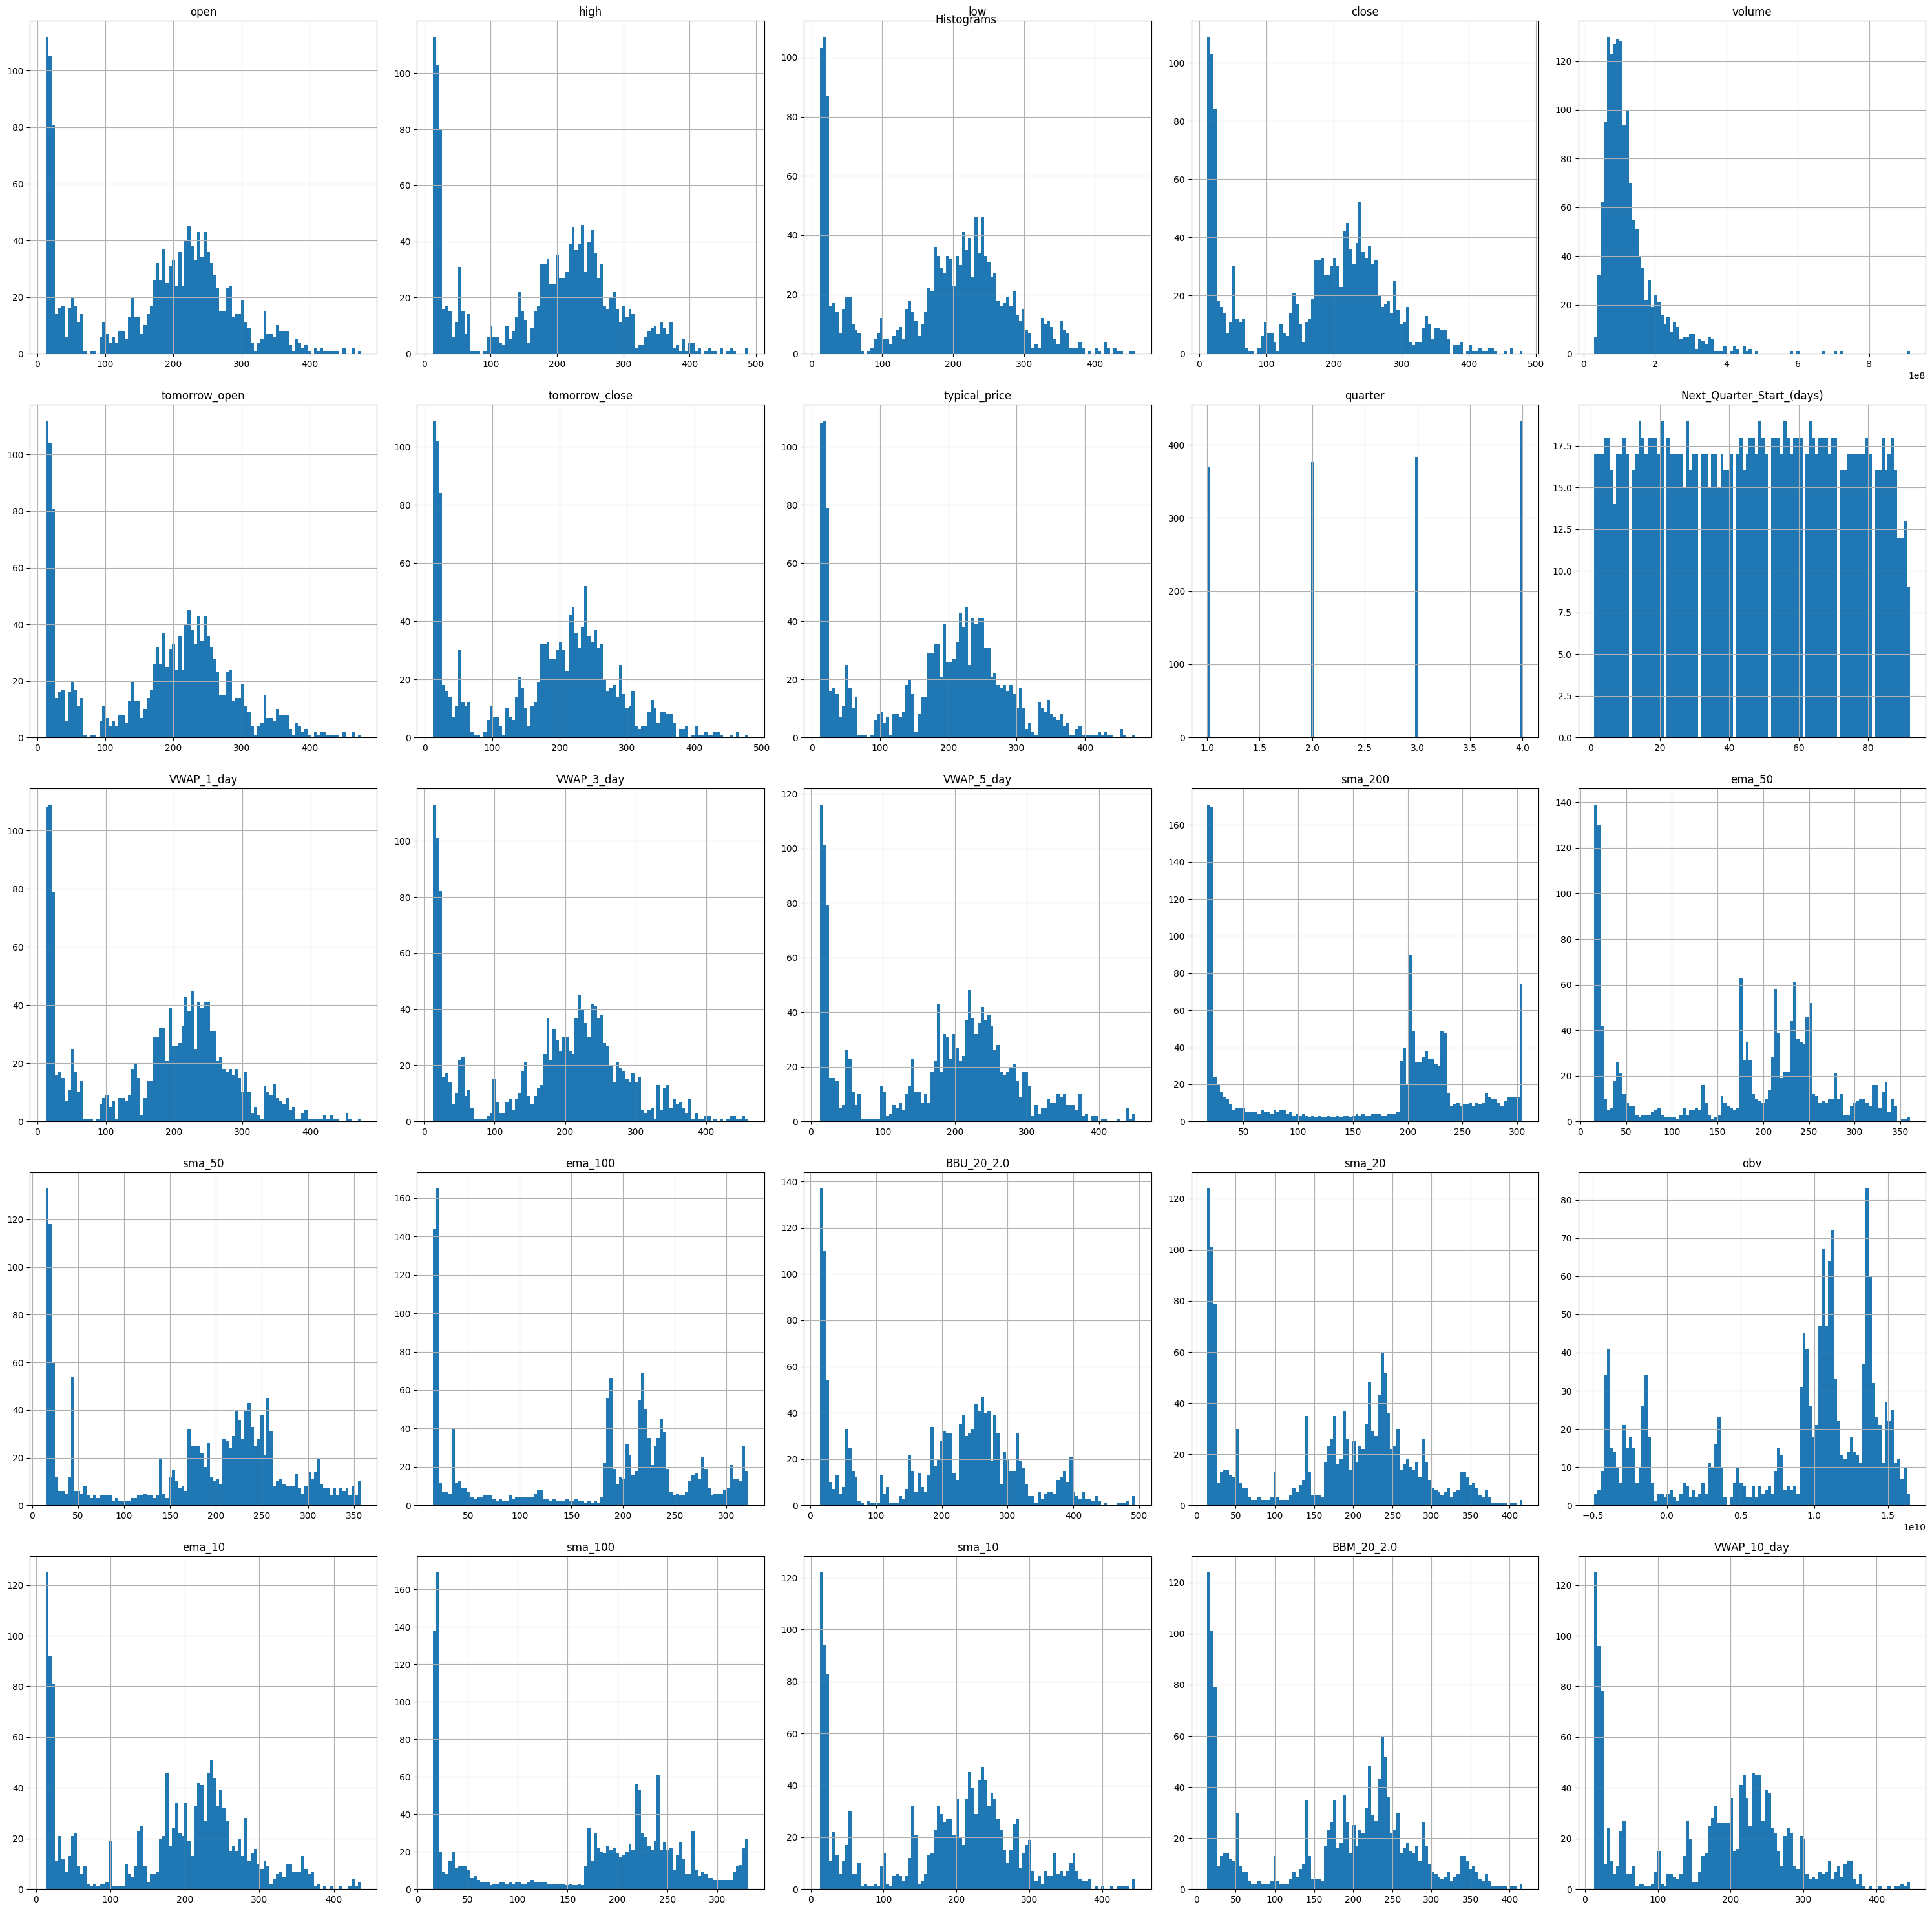

In [ ]:
# Histograms
numeric_columns.hist(figsize=(30, 30), bins=100)
plt.suptitle("Histograms")
plt.tight_layout()
plt.show()

May need to fix:

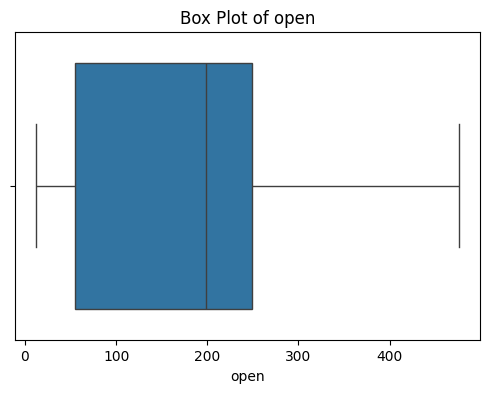

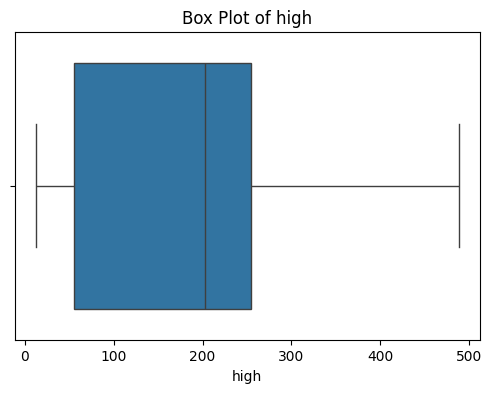

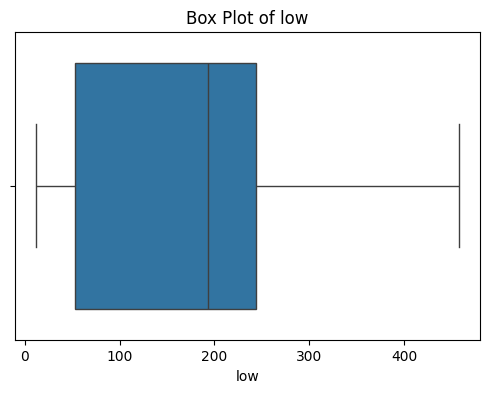

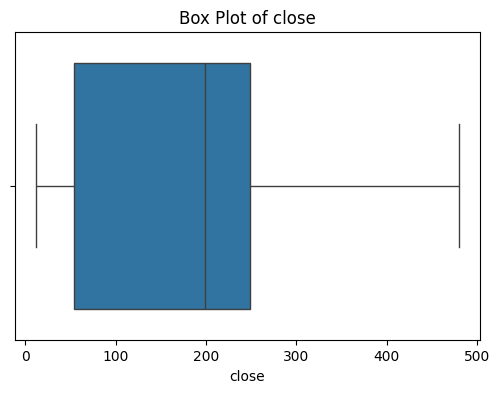

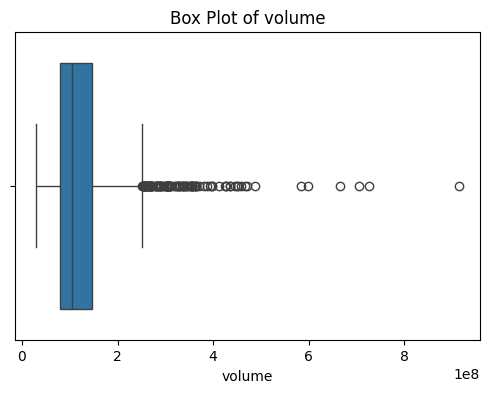

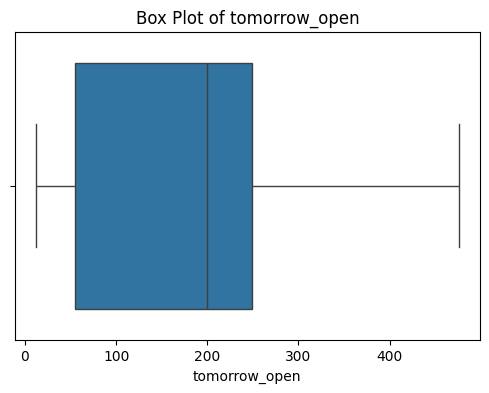

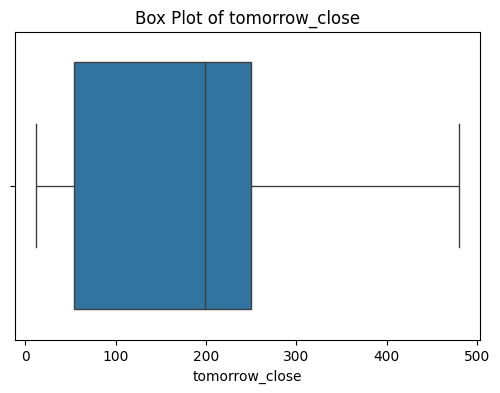

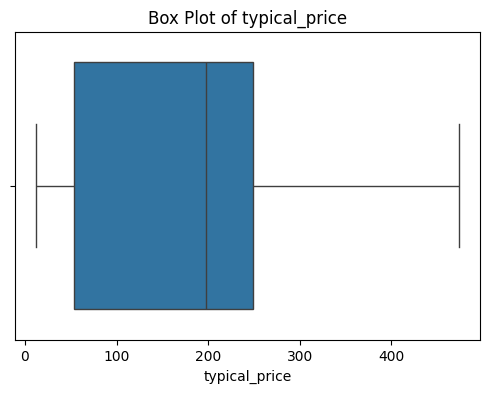

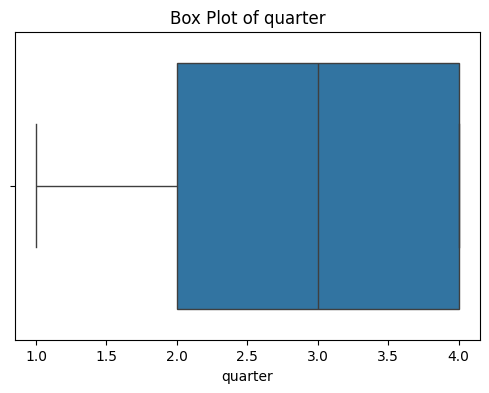

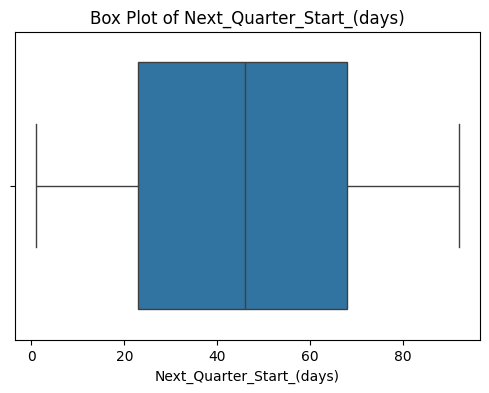

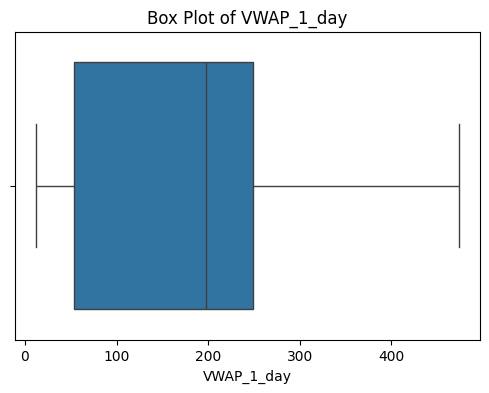

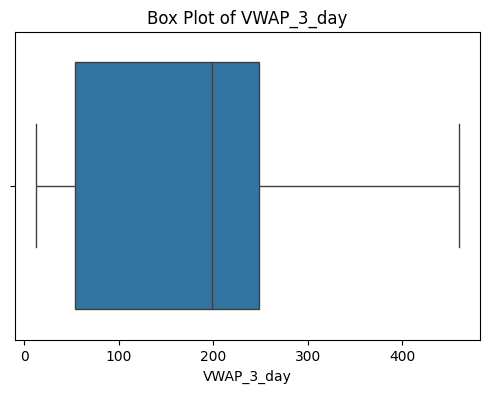

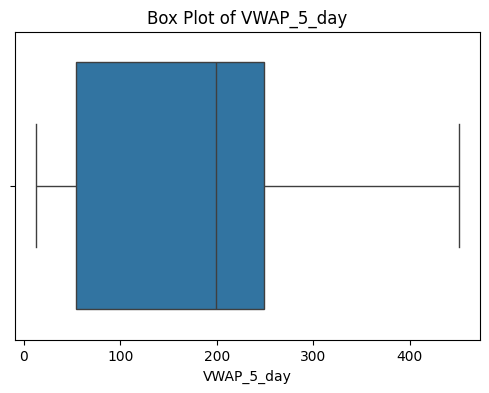

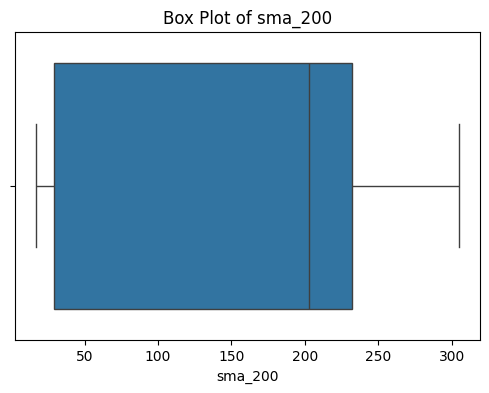

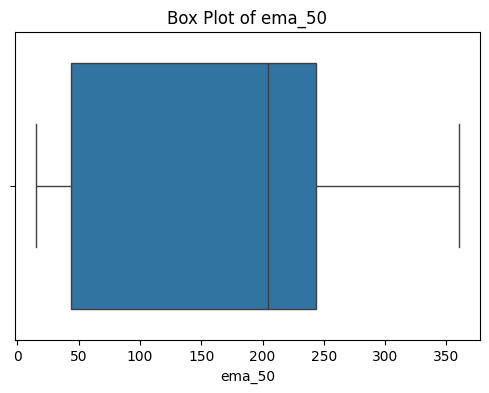

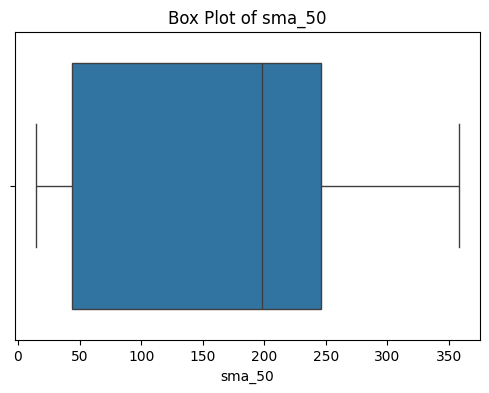

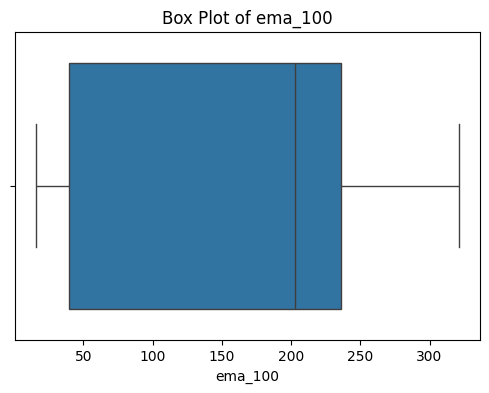

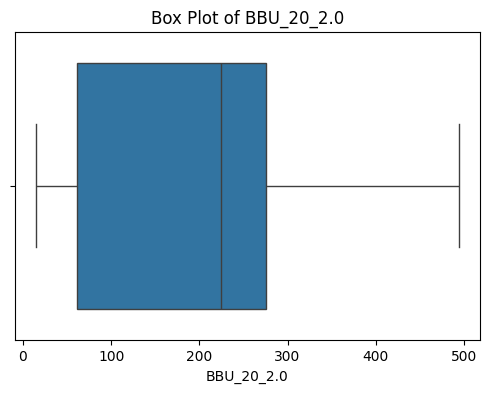

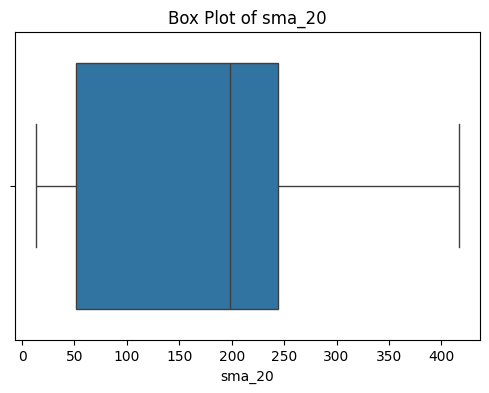

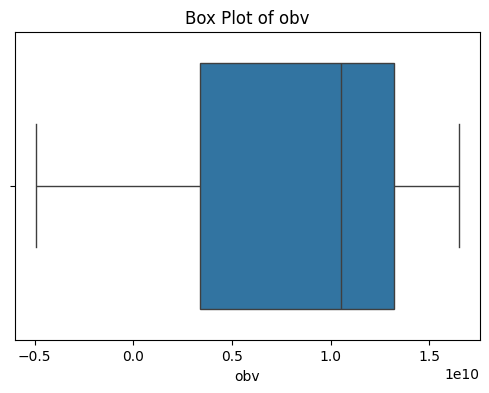

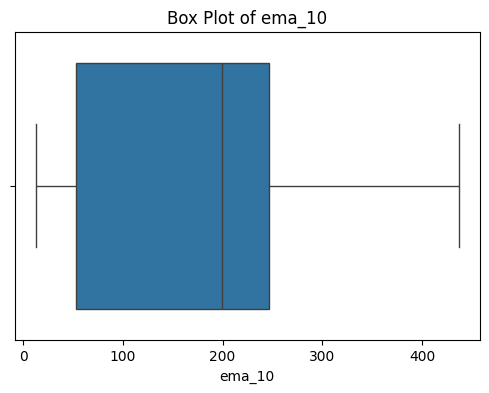

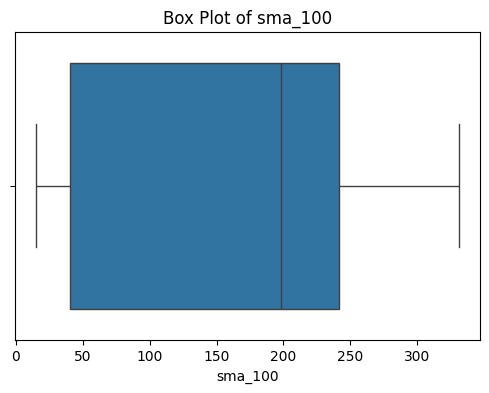

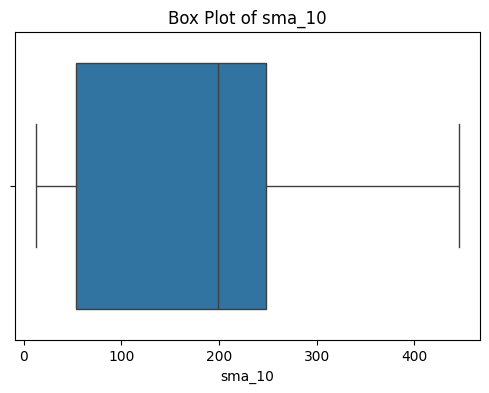

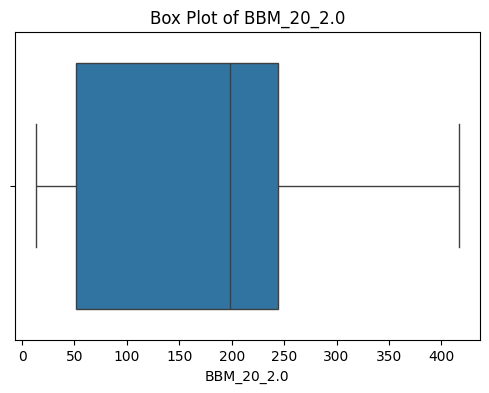

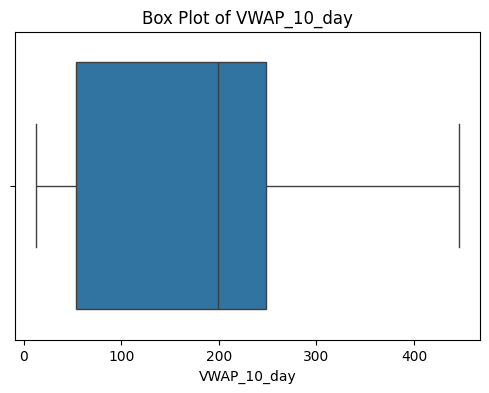

In [ ]:
# Boxplot

import seaborn as sns
import matplotlib.pyplot as plt

for column in numeric_columns:  # Ensure numeric_columns is a list of column names or DataFrame
    plt.figure(figsize=(6, 4))  # Set figure size
    sns.boxplot(data=df, x=column)  # Use df instead of numeric_columns if needed
    plt.title(f"Box Plot of {column}")
    #plt.xlabel("Value")  # Set correct label
    #plt.ylabel("Value")  # The y-axis represents the variable values
    plt.show()


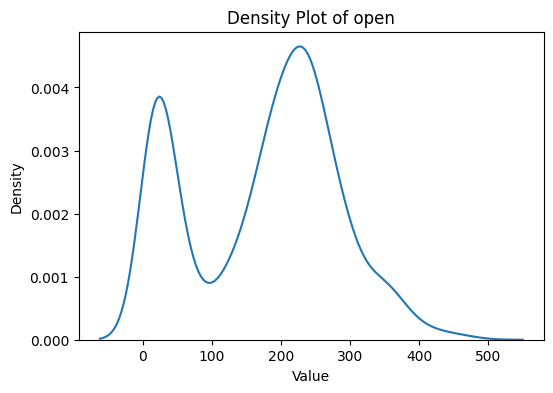

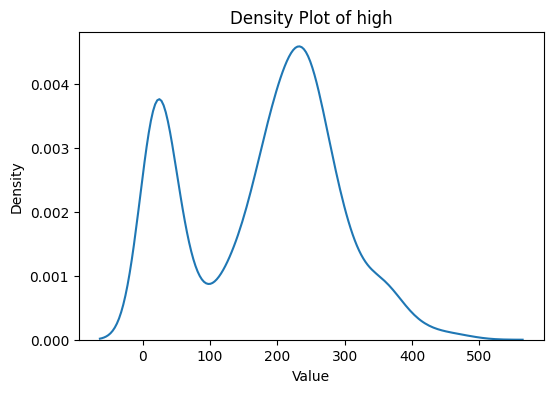

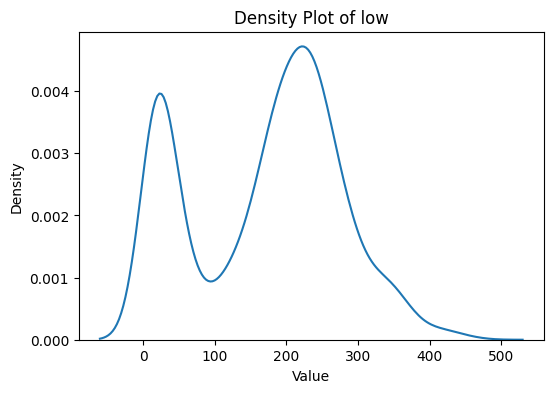

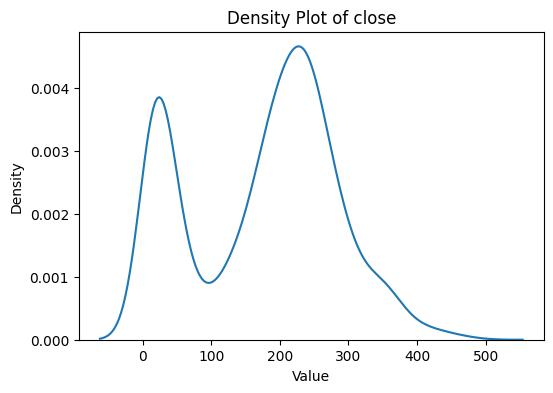

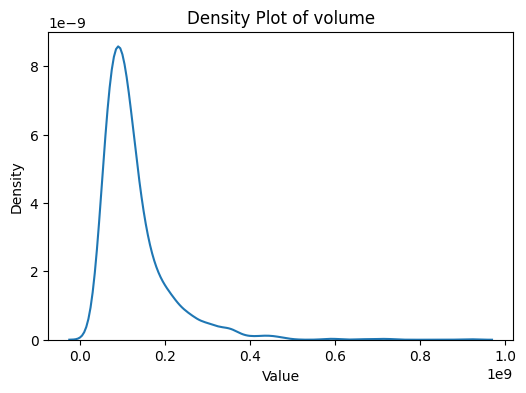

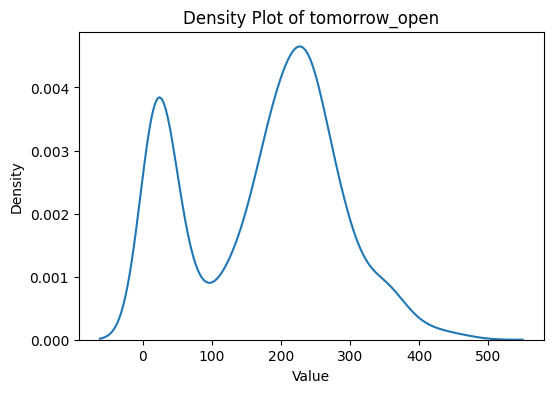

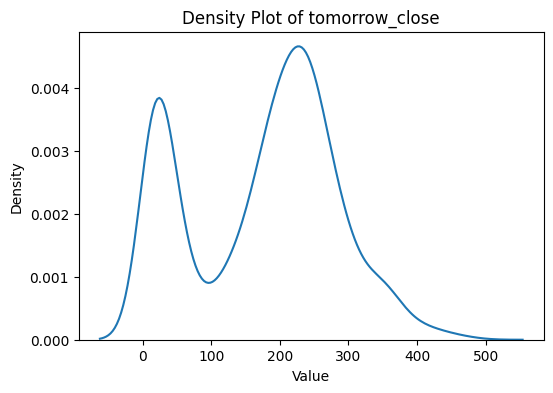

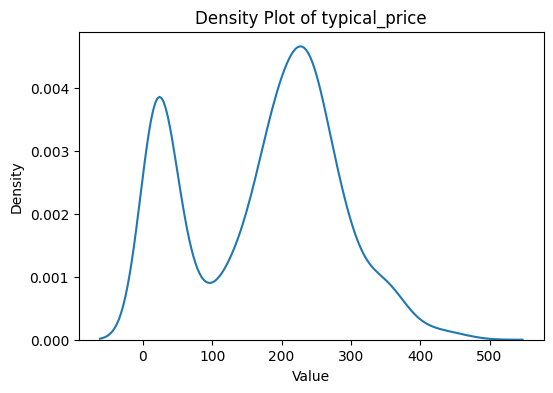

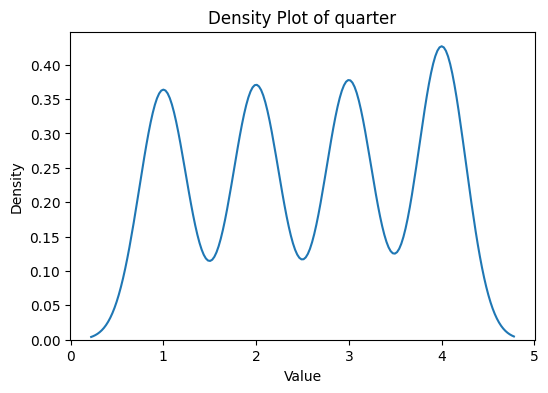

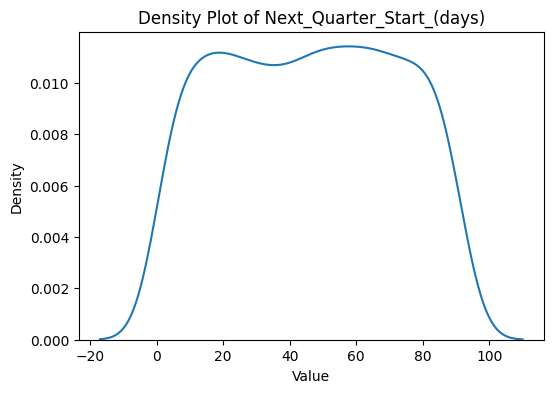

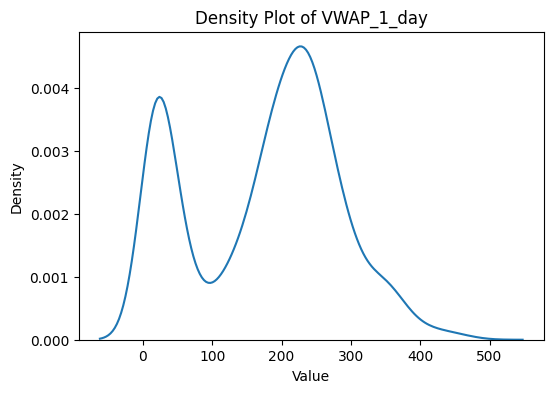

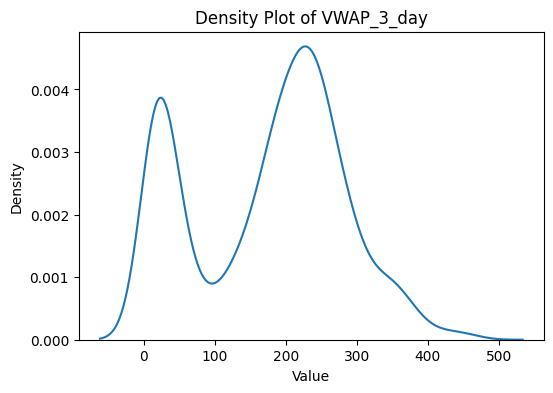

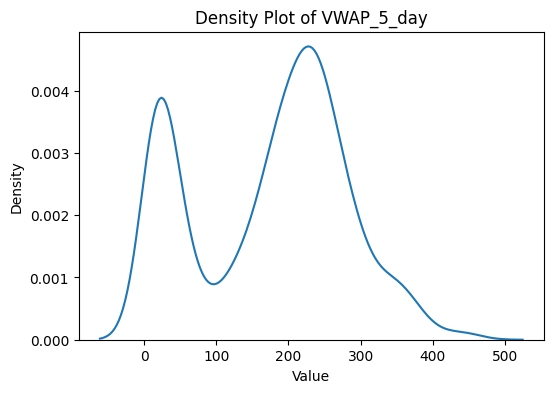

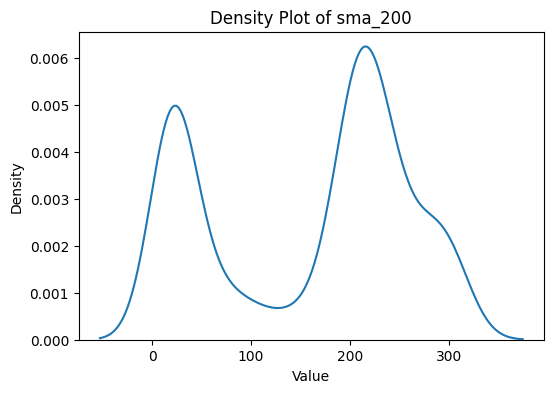

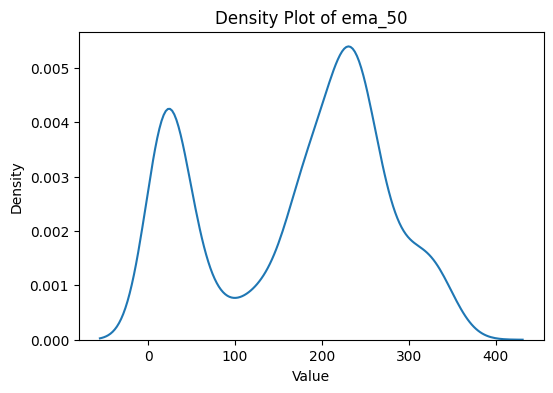

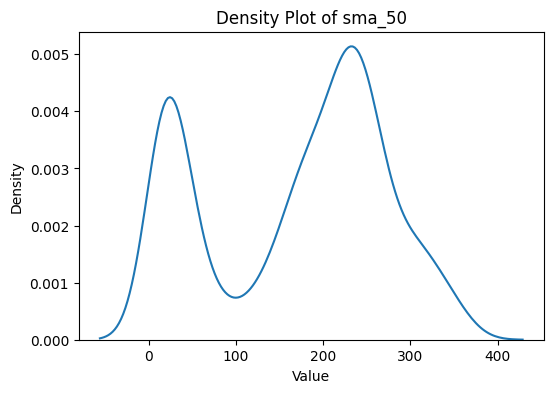

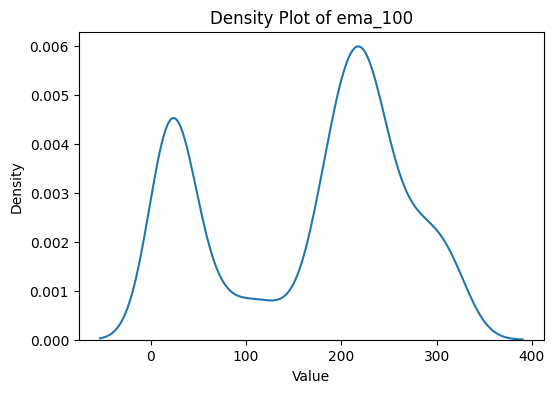

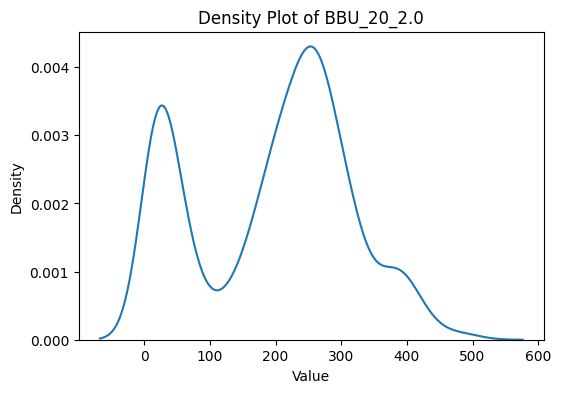

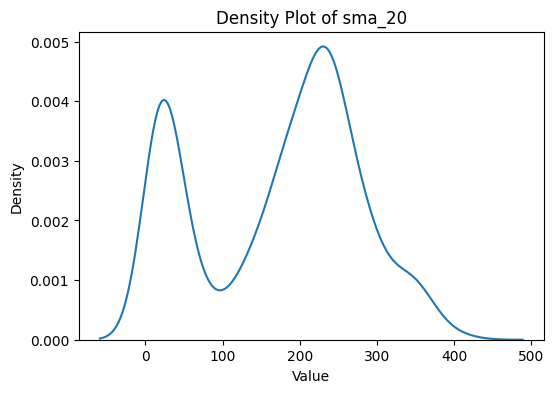

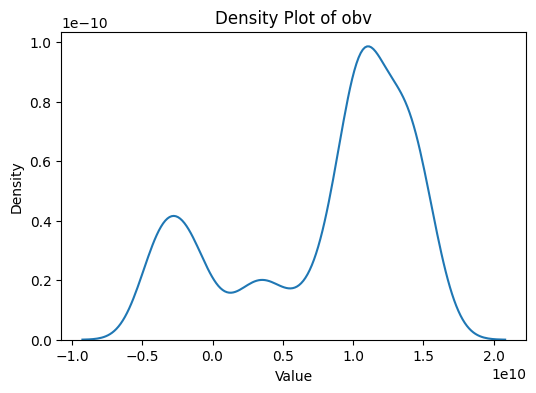

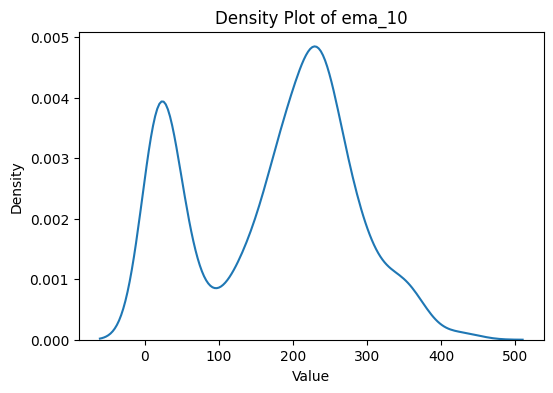

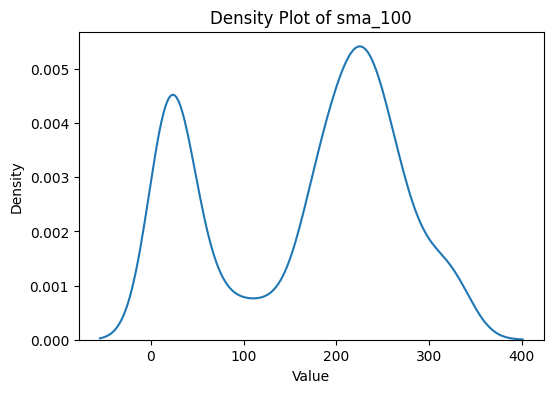

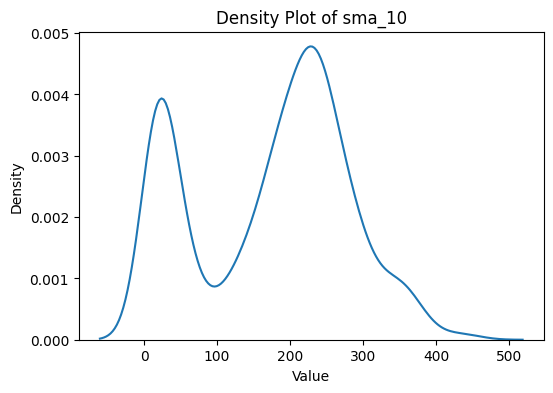

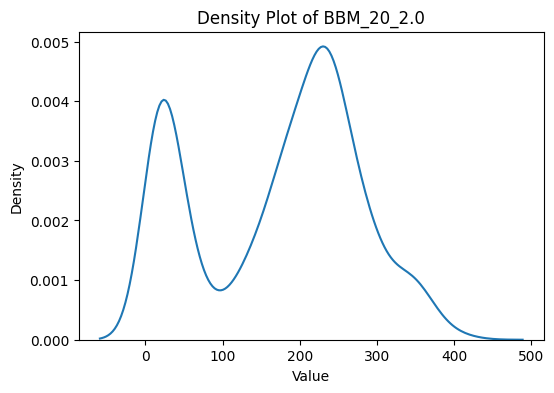

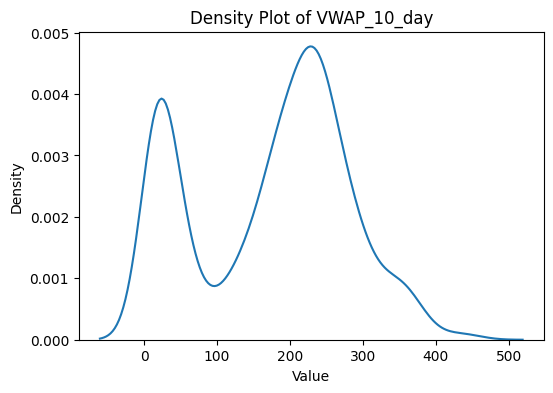

In [ ]:
# Density

for column in numeric_columns.columns:
    plt.figure(figsize=(6, 4))  # Set the figure size for each density plot
    sns.kdeplot(numeric_columns[column])  # Create the density plot for each column
    plt.title(f"Density Plot of {column}")  # Set the title for each plot
    plt.xlabel('Value')  # X-axis label
    plt.ylabel('Density')  # Y-axis label
    plt.show()  # Display the plot

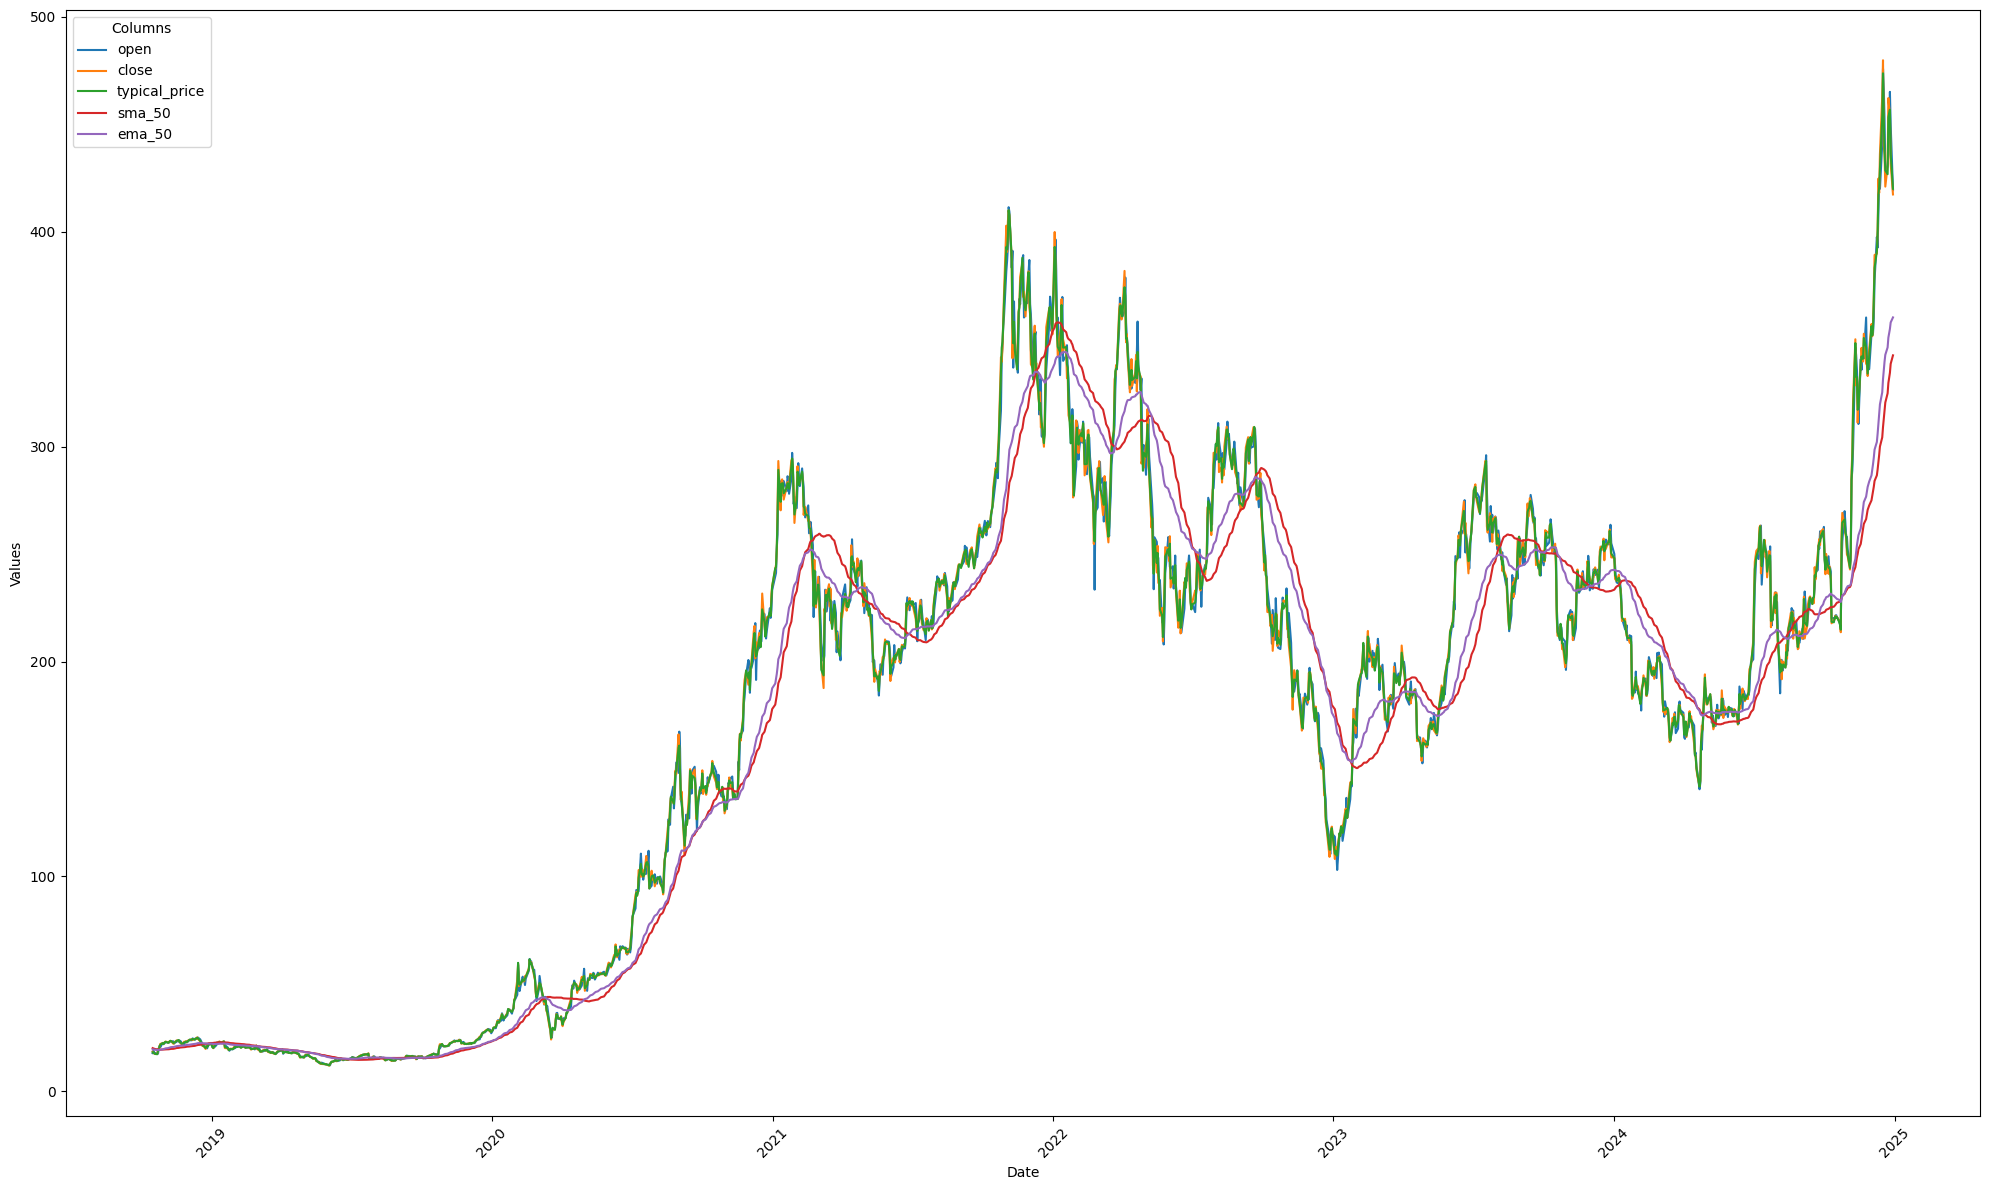

In [ ]:
plt.figure(figsize=(20, 12))  # Set the figure size

# Select only the columns you're interested in
columns_to_plot = ['open', 'close', 'typical_price', 'sma_50', 'ema_50']

# Loop through the selected columns
for column in columns_to_plot:
    sns.lineplot(x=df_final['date'], y=df_final[column], label=column)  # Plot each column

# Customize the plot
#plt.title("Line Graph of Selected Columns vs Date")  # Set title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Values')  # Y-axis label
plt.legend(title='Columns')  # Show legend
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

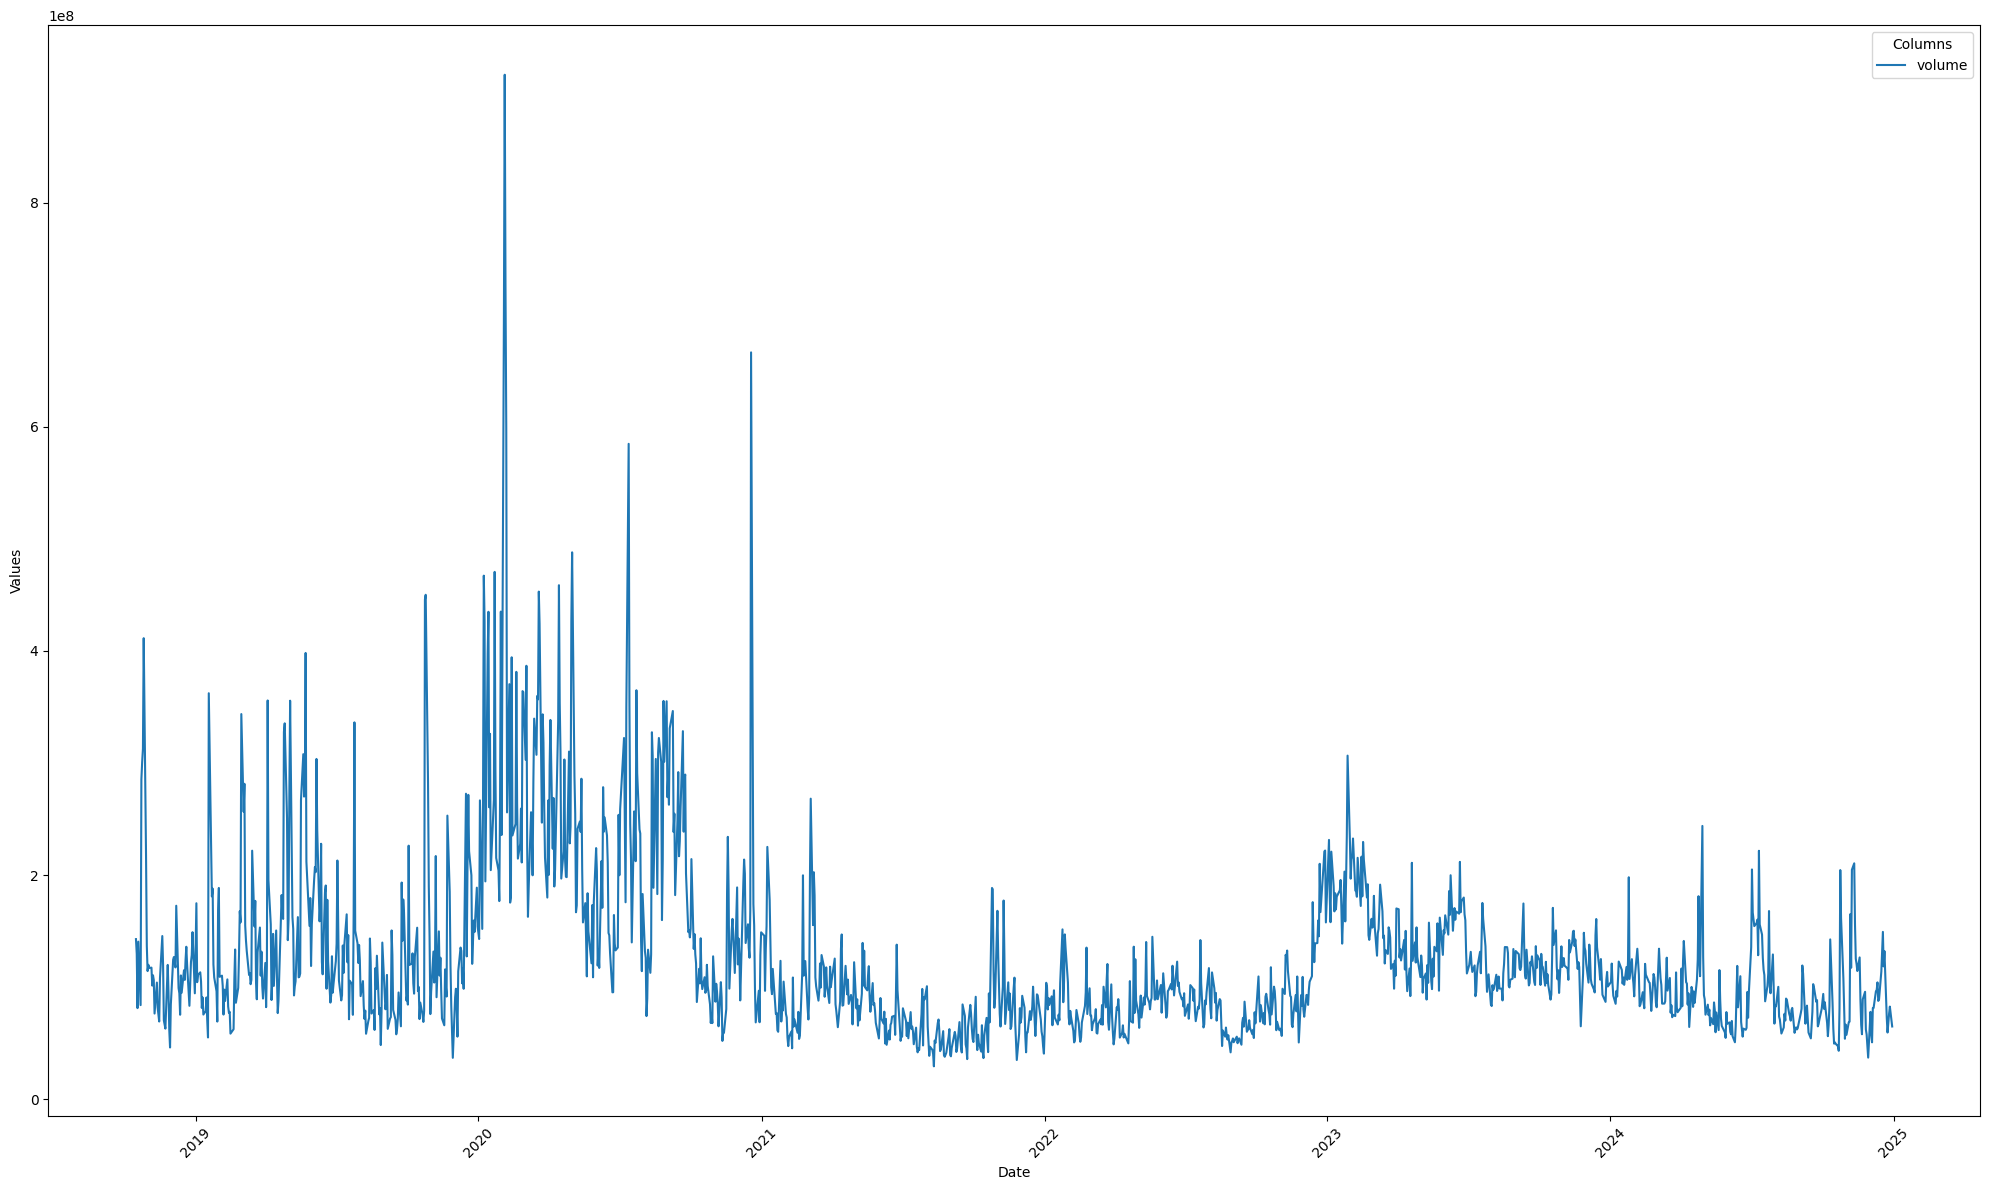

In [ ]:
# Volume

plt.figure(figsize=(20, 12))  # Set the figure size

# Select only the columns you're interested in
columns_to_plot = ['volume']

# Loop through the selected columns
for column in columns_to_plot:
    sns.lineplot(x=df_final['date'], y=df_final[column], label=column)  # Plot each column

# Customize the plot
#plt.title("Line Graph of Selected Columns vs Date")  # Set title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Values')  # Y-axis label
plt.legend(title='Columns')  # Show legend
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

## 2.3 Correlation Analysis

<Figure size 1500x1500 with 0 Axes>

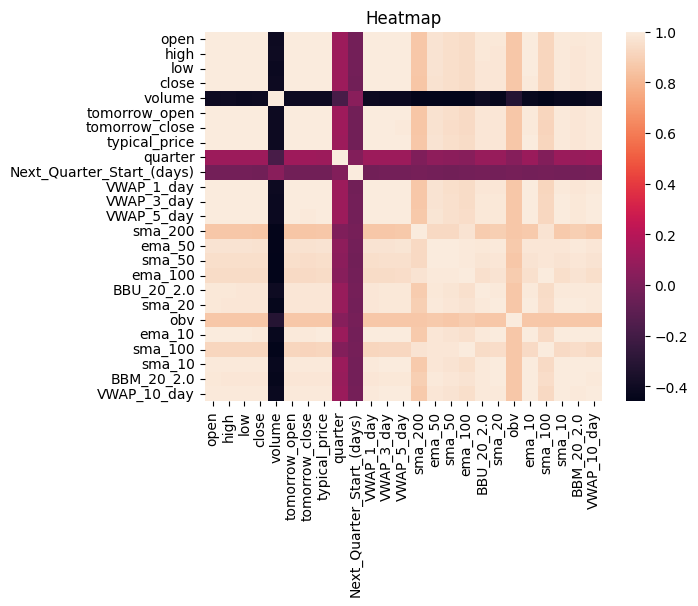

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# Heatmap

corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix)

plt.title("Heatmap")
plt.figure(figsize=(15, 15))

## 2.4 Identifying Trends

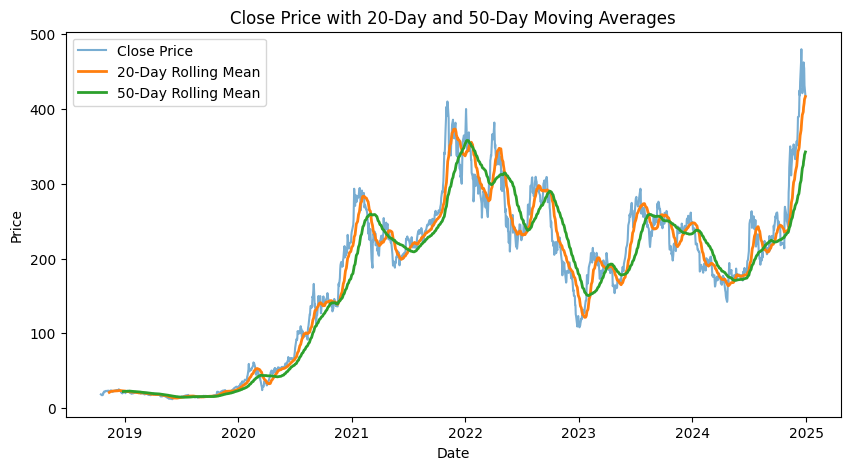

In [ ]:
# Calculate 20-Day Rolling Mean
df['rolling_mean'] = df['close'].rolling(window=20).mean()

# Calculate additional moving average (50-day)
df['rolling_mean_50'] = df['close'].rolling(window=50).mean()

plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['close'], label='Close Price', alpha=0.6)
plt.plot(df['date'], df['rolling_mean'], label='20-Day Rolling Mean', linewidth=2)
plt.plot(df['date'], df['rolling_mean_50'], label='50-Day Rolling Mean', linewidth=2)
plt.title("Close Price with 20-Day and 50-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


### As we can see here, the 20 day rolling mean is more accurate in capturing the trend of the data.

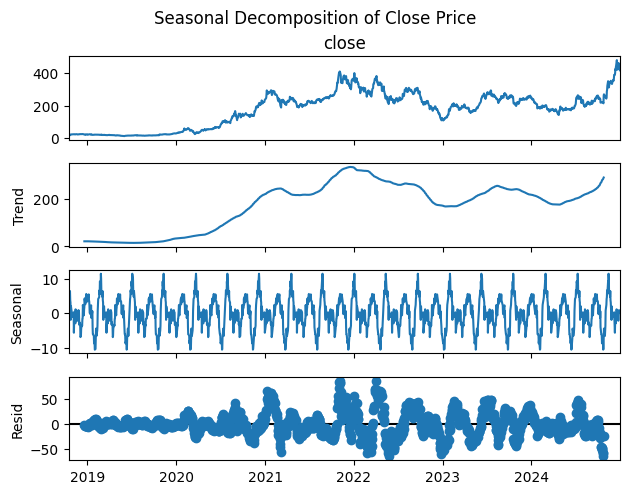

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the DataFrame is sorted by date and set date as index
df_ts = df.set_index('date').sort_index()
result = seasonal_decompose(df_ts['close'], model='additive', period=90)  # period approximates a quarter
result.plot()
plt.suptitle("Seasonal Decomposition of Close Price", y=1.02)
plt.show()


### Helps to highlight any repeating patterns or seasonal effects that might not be visible in the raw data.

## 2.5 Volatility Analysis

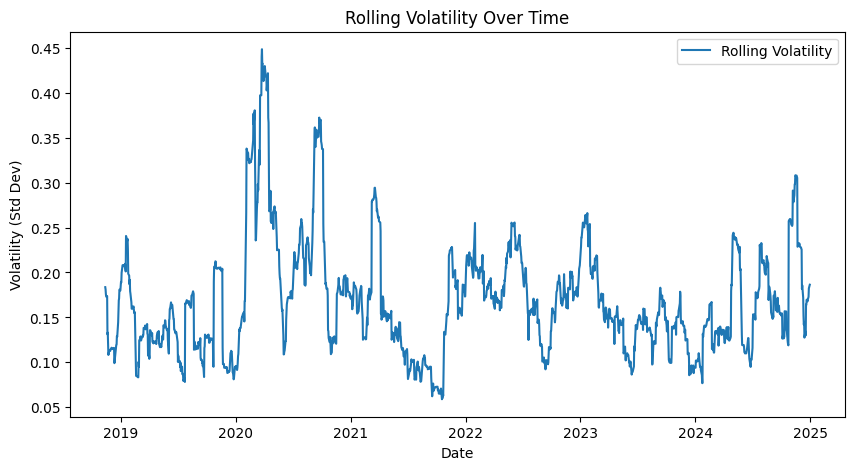

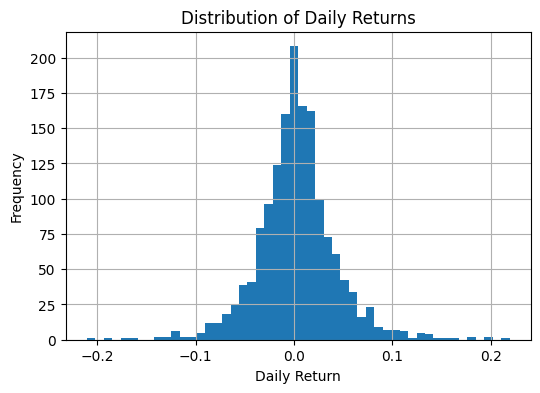

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily returns (percent change from previous day)
df['daily_return'] = df['close'].pct_change()

# Rolling volatility (using a 20-day rolling window as an example)
window_vol = 20
df['rolling_vol'] = df['daily_return'].rolling(window_vol).std() * np.sqrt(window_vol)

# Plot rolling volatility
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['rolling_vol'], label='Rolling Volatility')
plt.title("Rolling Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility (Std Dev)")
plt.legend()
plt.show()

# Distribution of Daily Returns
plt.figure(figsize=(6, 4))
df['daily_return'].hist(bins=50)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


### After 2020, volatility never returns to a perfectly stable, low level. Instead, it flows in cycles, with moderate spikes around ~0.25–0.30 at various points.

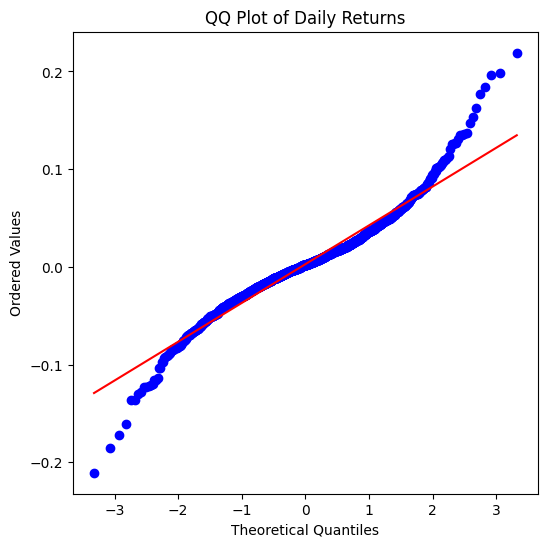

In [ ]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(df['daily_return'].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot of Daily Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()


### the QQ plot shows mild to moderate departures from normality in the tails, but the core distribution is fairly close to normal.

# 3 Data Preparation for LSTM Model

## 3.1 Splitting Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
df_final.shape

(1561, 26)

In [ ]:
# First, separate features and target before scaling
X = df_final.drop(columns=['date', 'tomorrow_close'])
y = df_final[['tomorrow_close']]

# Scale features and target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 3.2 Time-Series Forecasting Sequences

In [ ]:
def create_dataset(X, y, time_steps=60):
    X_data, y_data = [], []
    for i in range(time_steps, len(X)):
        X_data.append(X[i-time_steps:i, :])
        y_data.append(y[i])
    return np.array(X_data), np.array(y_data)

# Create dataset with time_steps = 60
X_data, y_data = create_dataset(X_scaled, y_scaled, time_steps=20)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1232, 20, 24)
y_train shape: (1232, 1)


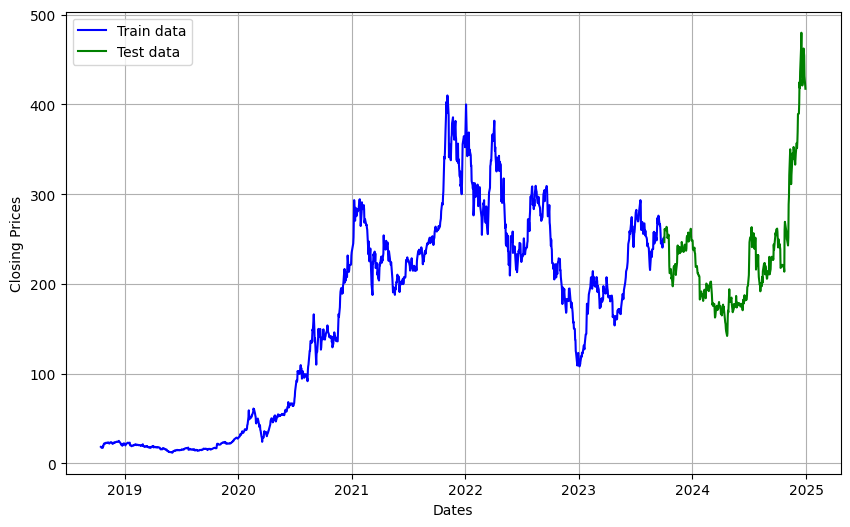

In [ ]:
# Select the first 80% for training data
train_data = df_final[['date', 'close']].iloc[:int(0.8 * len(df_final))]

# Select the last 20% for testing data
test_data = df_final[['date', 'close']].iloc[int(0.8 * len(df_final)):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['date'], train_data['close'], 'b', label='Train data')
plt.plot(test_data['date'], test_data['close'], 'g', label='Test data')
plt.legend()

## 3.3 Reshaping Data

# 4 LSTM Model

## 4.1 Model Architecture

In [ ]:
# LSTM model in TensorFlow
model = models.Sequential()

# LSTM Layer
model.add(layers.LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout Layer
model.add(layers.Dropout(0.2))

# Dense Layer
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 4.2 Training Model

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0426 - val_loss: 0.0020
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0073 - val_loss: 0.0014
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0053 - val_loss: 9.9694e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 9.0089e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - val_loss: 8.8164e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - val_loss: 8.9767e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - val_loss: 9.7044e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025 - val_loss: 8.5114e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 8.2970e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 7.7706e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━

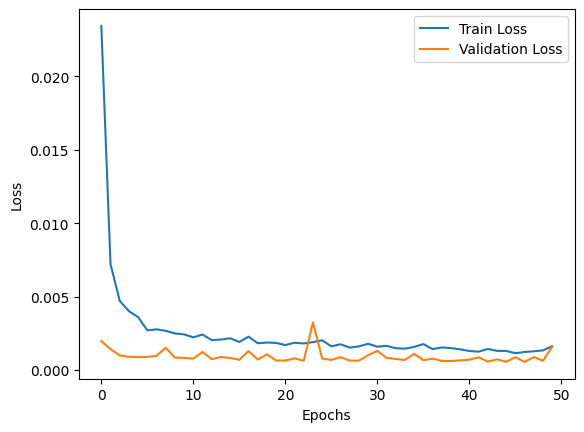

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5 Model Evaluation

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test RMSE: 22.08938832270734


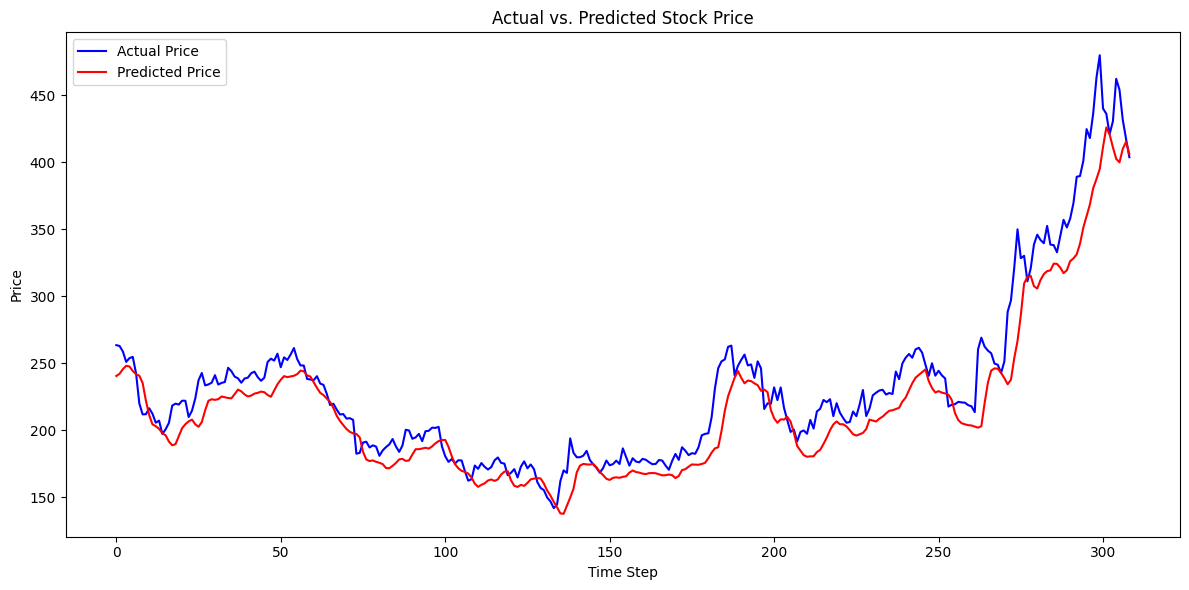

In [ ]:
# Predict and inverse transform
predictions_scaled = model.predict(X_test)
predictions_unscaled = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))
print("Test RMSE:", rmse)

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled, label='Actual Price', color='b')
plt.plot(predictions_unscaled, label='Predicted Price', color='r')
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Price")
plt.legend()
plt.tight_layout()
plt.show()

## 5.1 Performance Metrics

<Figure size 1200x400 with 0 Axes>

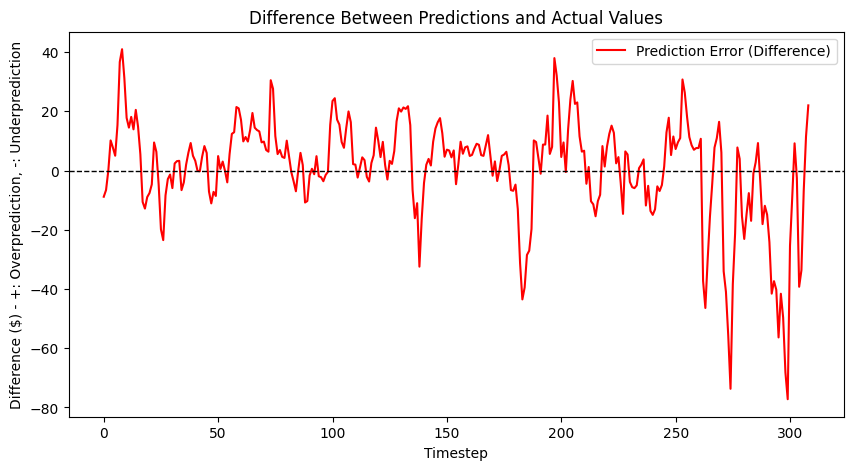

In [ ]:
# Calculate differences (Predicted - Actual)
differences = predictions_unscaled - y_test_unscaled

plt.figure(figsize=(12, 4))  # Wider, shorter plot for time series

# Plot differences
plt.figure(figsize=(10, 5))
plt.plot(differences, label="Prediction Error (Difference)", color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at 0
plt.xlabel("Timestep")
plt.ylabel("Difference ($) - +: Overprediction, -: Underprediction")
plt.title("Difference Between Predictions and Actual Values")
plt.legend()
plt.show()

In [ ]:
# Calculate error statistics
error_stats = {
    "Min Error": [np.min(differences)],
    "Max Error": [np.max(differences)],
    "Mean Error": [np.mean(differences)]
}

# Create a DataFrame for better formatting
error_df = pd.DataFrame(error_stats)

# Display the table
print(error_df.to_string(index=False))

 Min Error  Max Error  Mean Error
-84.838593  23.417221  -15.209529


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calculate additional metrics
metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled)),
    "MAE": mean_absolute_error(y_test_unscaled, predictions_unscaled),
    "MAPE (%)": mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled) * 100,
    "R²": r2_score(y_test_unscaled, predictions_unscaled)
}

# Convert to DataFrame for pretty display
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print("\nModel Performance Metrics:")
print(metrics_df.round(3))


Model Performance Metrics:
           Value
RMSE      22.089
MAE       16.566
MAPE (%)   6.802
R²         0.883


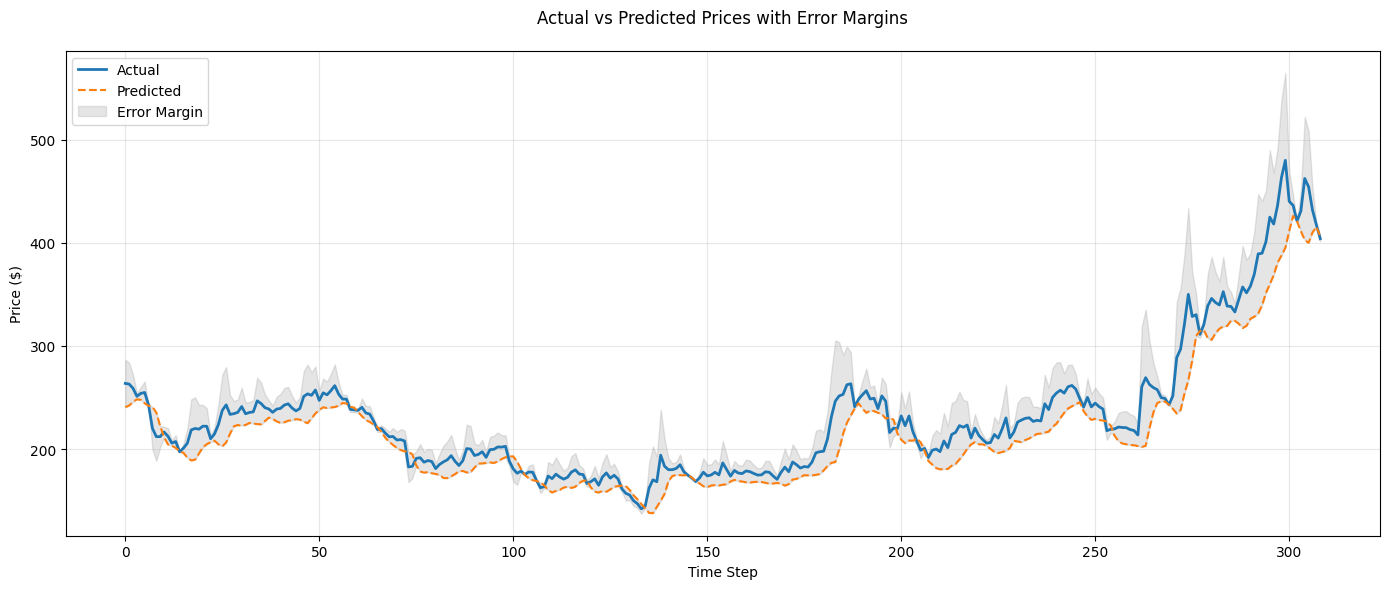

In [ ]:
plt.figure(figsize=(14, 6))

# Plot actual and predicted values
plt.plot(y_test_unscaled, label='Actual', color='#1f77b4', linewidth=2)
plt.plot(predictions_unscaled, label='Predicted', color='#ff7f0e', linestyle='--')

# Add error shading
errors = predictions_unscaled.flatten() - y_test_unscaled.flatten()
abs_errors = np.abs(errors)
plt.fill_between(range(len(y_test_unscaled)),
                 y_test_unscaled.flatten() - abs_errors,
                 y_test_unscaled.flatten() + abs_errors,
                 color='gray', alpha=0.2, label='Error Margin')

plt.title('Actual vs Predicted Prices with Error Margins', pad=20)
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

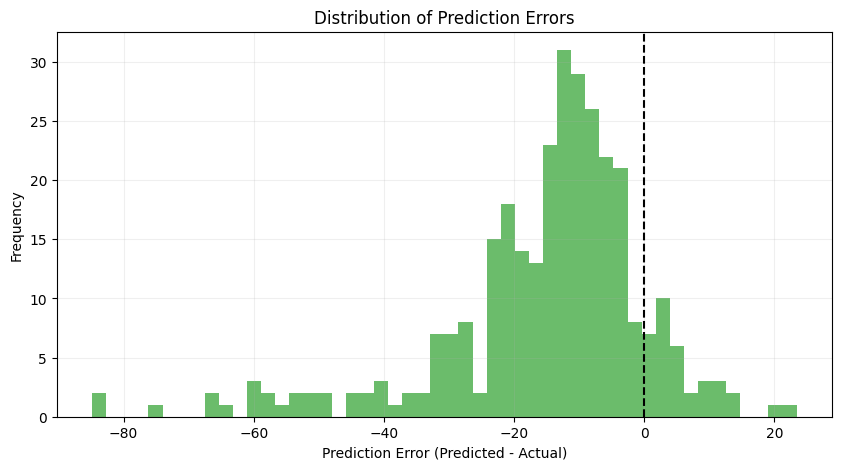

In [ ]:
# Error Distribution Histogram
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='#2ca02c', alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(alpha=0.2)
plt.show()

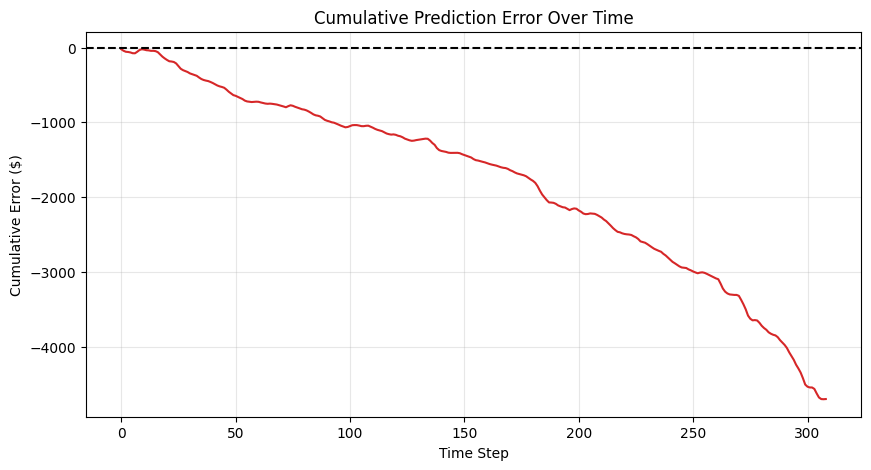

In [ ]:
# Cumulative Error Analysis
cumulative_error = np.cumsum(errors)
plt.figure(figsize=(10, 5))
plt.plot(cumulative_error, color='#d62728')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Error ($)')
plt.grid(alpha=0.3)
plt.show()

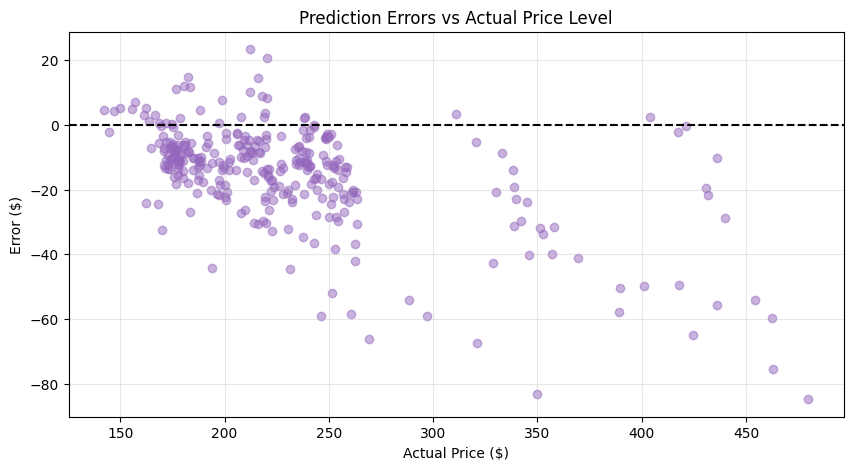

In [ ]:
# Error vs. Price Level
plt.figure(figsize=(10, 5))
plt.scatter(y_test_unscaled, errors, alpha=0.5, color='#9467bd')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Prediction Errors vs Actual Price Level')
plt.xlabel('Actual Price ($)')
plt.ylabel('Error ($)')
plt.grid(alpha=0.3)
plt.show()

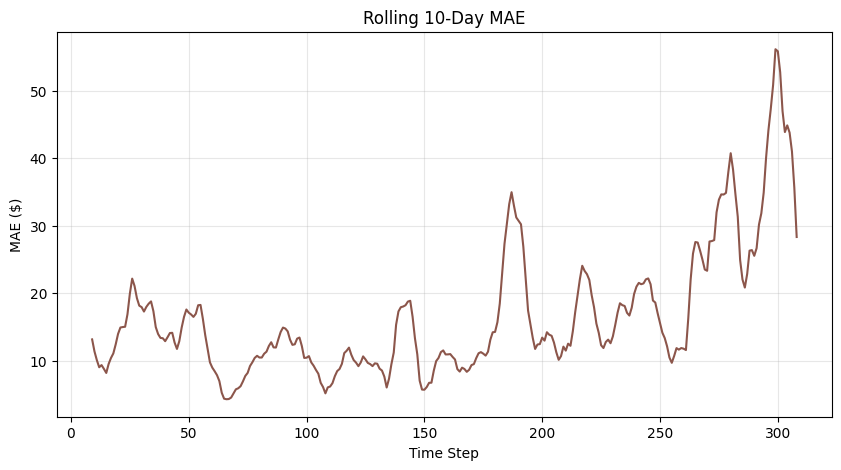

In [ ]:
#  Rolling Error Metrics
window_size = 10  # Adjust based on your data size
rolling_mae = pd.Series(abs_errors).rolling(window=window_size).mean()

plt.figure(figsize=(10, 5))
plt.plot(rolling_mae, color='#8c564b')
plt.title(f'Rolling {window_size}-Day MAE')
plt.xlabel('Time Step')
plt.ylabel('MAE ($)')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Key Takeaways Table
analysis = {
    "Bias Direction": ["Overpredicts" if np.mean(errors) > 0 else "Underpredicts"],
    "Worst Single Error": [f"${np.max(abs_errors):.2f}"],
    "Typical Error Range": [f"±${np.percentile(abs_errors, 50):.2f} to ±${np.percentile(abs_errors, 90):.2f}"],
    "Error Stability": ["Improving" if rolling_mae.iloc[-1] < rolling_mae.iloc[0] else "Worsening"]
}

pd.DataFrame.from_dict(analysis, orient='index', columns=['Findings'])

,Findings
Bias Direction,Underpredicts
Worst Single Error,$84.84
Typical Error Range,±$12.45 to ±$32.47
Error Stability,Worsening


## 5.2 Visualizing Results

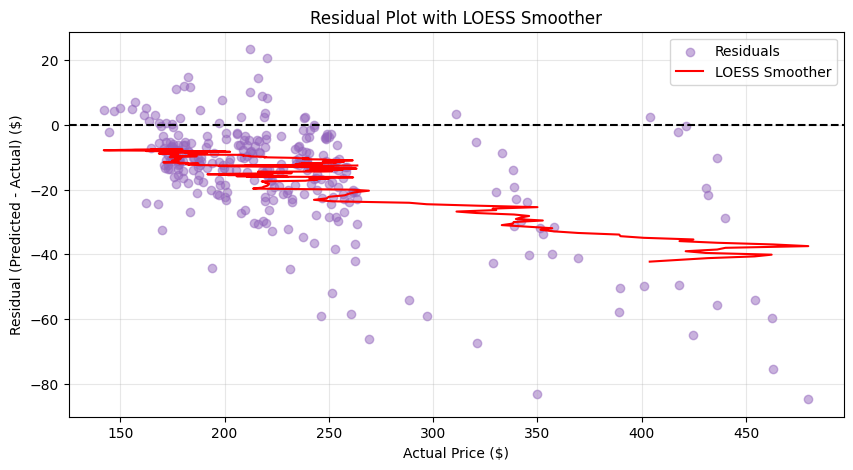

<Figure size 1000x500 with 0 Axes>

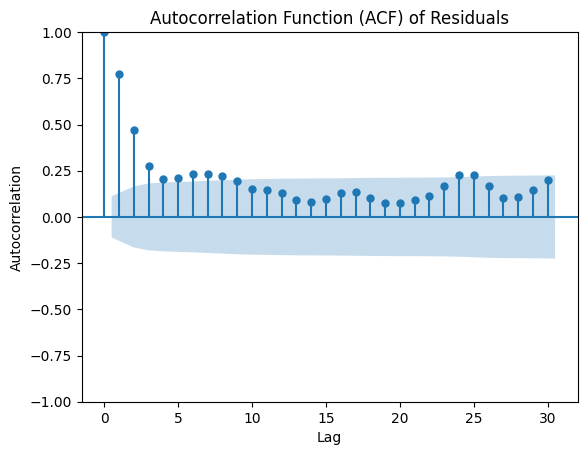

<Figure size 1000x500 with 0 Axes>

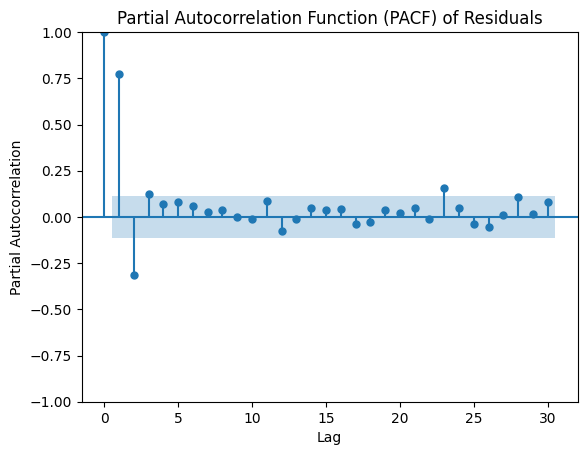

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Residual Plot with LOESS Smoother
from statsmodels.nonparametric.smoothers_lowess import lowess

residuals = predictions_unscaled.flatten() - y_test_unscaled.flatten()
smoothed_residuals = lowess(residuals, np.arange(len(residuals)), frac=0.3)

plt.figure(figsize=(10, 5))
plt.scatter(y_test_unscaled, residuals, alpha=0.5, color='#9467bd', label='Residuals')
plt.plot(y_test_unscaled, smoothed_residuals[:, 1], color='red', label='LOESS Smoother')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot with LOESS Smoother')
plt.xlabel('Actual Price ($)')
plt.ylabel('Residual (Predicted - Actual) ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Autocorrelation Function (ACF) of Residuals
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Partial Autocorrelation Function (PACF) of Residuals
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=30)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


## 5.3 Error Analysis

# 6 Model Testing

## 6.1 Test

## 6.2 Visualizing Model Test Results

## 6.3 Performance Comparison

# 7 Model Improvements

## 7.0 Overfitting/Underfitting

Overfitting Prevention Techniques Used

L2 Regularization: Prevents large weights

Dropout: Randomly drops neurons to improve generalization

Batch Normalization: Stabilizes training and reduces internal covariate shift

Early Stopping: Stops training if validation loss increases

Hyperparameter Tuning: Finds the best LSTM units, dense layers, learning rate, etc.

## 7.1 Hyperparameter Tuning

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Define the model-building function for hyperparameter tuning
def build_lstm_model(hp):
    model = keras.Sequential()

    # LSTM Layer with a limited number of units
    model.add(layers.LSTM(
        units=hp.Int('lstm_units', min_value=25, max_value=125, step=25),
        return_sequences=False,  # Only final output, not sequences
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Dropout Layer with a few options
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.2)))

    # Dense Layer (output layer with 1 unit for regression)
    model.add(layers.Dense(1))

    # Compile the model with Adam optimizer and MSE loss function
    optimizer = keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[0.001, 0.0005])  # Reduced learning rate options
    )
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=20,  # Number of different hyperparameter combinations
    executions_per_trial=1,  # Number of times to train each model
    directory='lstm_tuning',
    project_name='lstm_hyperparameter_tuning'
)

Early stopping to prevent overfitting

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_split=0.1,
             callbacks=[early_stopping])

Trial 20 Complete [00h 00m 13s]
val_loss: 0.000851633318234235

Best val_loss So Far: 0.0005867254221811891
Total elapsed time: 00h 07m 39s


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0316 - val_loss: 0.0029
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032 - val_loss: 9.1519e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - val_loss: 7.5452e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025 - val_loss: 7.4028e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0022 - val_loss: 6.9682e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/

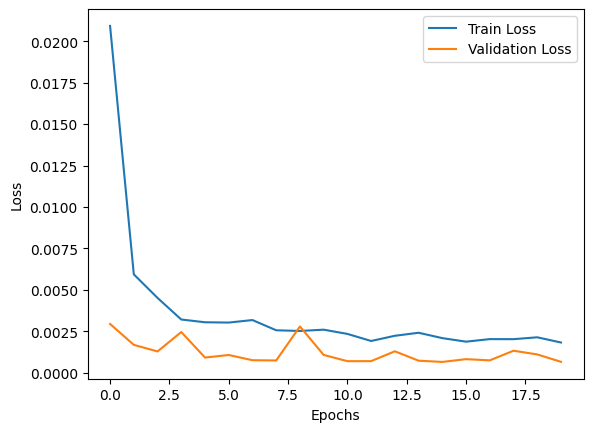

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history_best = best_model.fit(X_train, y_train,
                         epochs=50,
                         batch_size=32,
                         validation_split=0.1,
                         callbacks=[early_stopping])

plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on test set
best_model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0467e-04


0.00136364356148988

In [ ]:
model.save('best_model.keras')

## 7.3 Cross-validation

# 8 Final Model

## 8.1 Model Summary

In [ ]:
# Print the best hyperparameters
print("Best Model Hyperparameters After Tuning:")
for param in best_hps.space:
    print(f"{param.name}: {best_hps.get(param.name)}")

Best Model Hyperparameters After Tuning:
lstm_units: 125
dropout_rate: 0.4
learning_rate: 0.001


## 8.2 Model Performance

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test RMSE (Best Model): 17.279456178482324


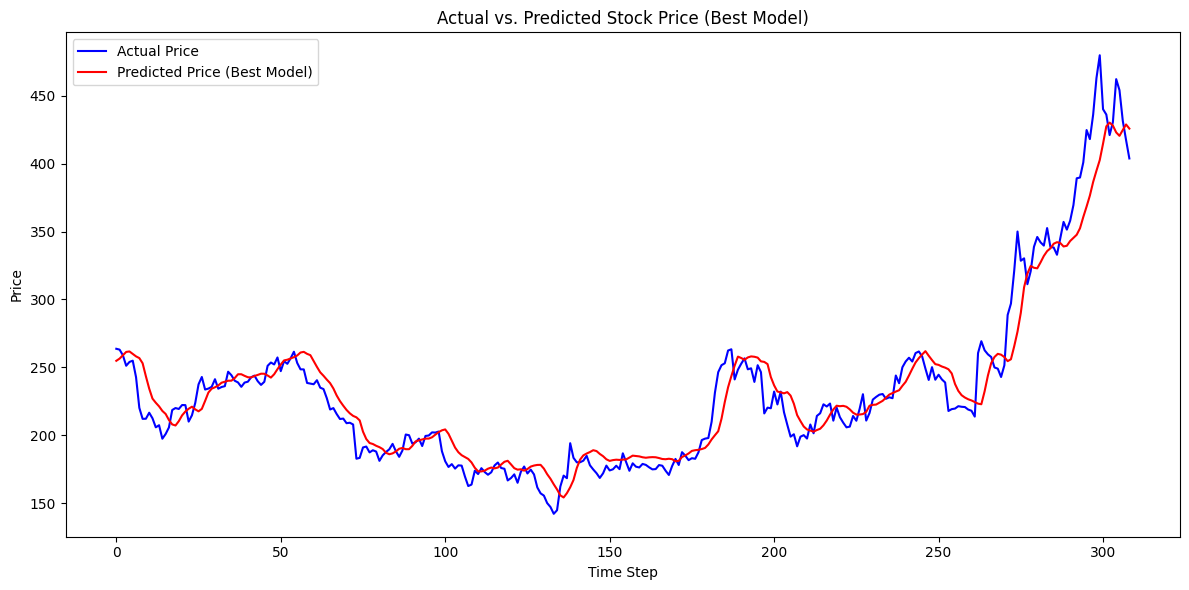

In [ ]:
# Predict using the best model
predictions_scaled_best = best_model.predict(X_test)

# Inverse transform to get the actual values
predictions_unscaled_best = scaler_y.inverse_transform(predictions_scaled_best.reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled_best))
print("Test RMSE (Best Model):", rmse)

# Plot Actual vs Predicted Stock Price
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled, label='Actual Price', color='b')
plt.plot(predictions_unscaled_best, label='Predicted Price (Best Model)', color='r')
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Price (Best Model)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calculate additional metrics
metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled_best)),
    "MAE": mean_absolute_error(y_test_unscaled, predictions_unscaled_best),
    "MAPE (%)": mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled_best) * 100,
    "R²": r2_score(y_test_unscaled, predictions_unscaled_best)
}

# Convert to DataFrame for pretty display
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print("\nBest Model Performance Metrics:")
print(metrics_df.round(3))


Best Model Performance Metrics:
           Value
RMSE      17.279
MAE       12.314
MAPE (%)   5.205
R²         0.928


**Need to fix this:**

<Figure size 1200x400 with 0 Axes>

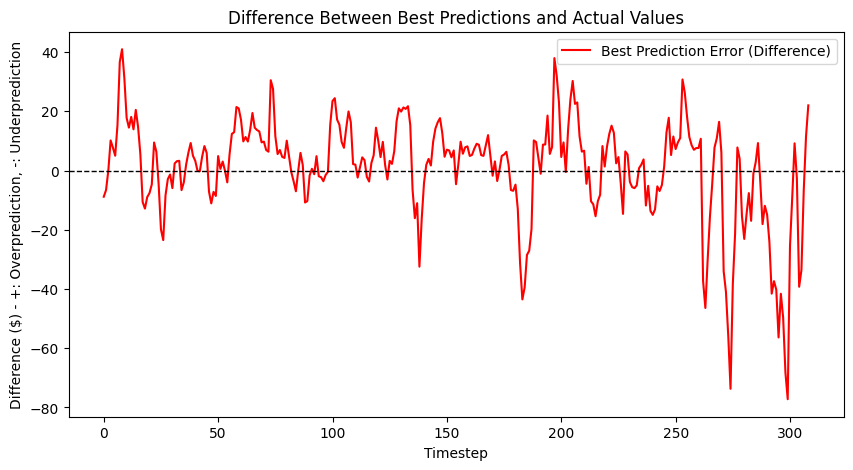

 Min Error  Max Error  Mean Error
 -77.24118  40.958954    0.626003


In [ ]:
# Calculate differences (Predicted - Actual)
differences_best = predictions_unscaled_best - y_test_unscaled

plt.figure(figsize=(12, 4))  # Wider, shorter plot for time series

# Plot differences
plt.figure(figsize=(10, 5))
plt.plot(differences_best, label="Best Prediction Error (Difference)", color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at 0
plt.xlabel("Timestep")
plt.ylabel("Difference ($) - +: Overprediction, -: Underprediction")
plt.title("Difference Between Best Predictions and Actual Values")
plt.legend()
plt.show()

# Calculate error statistics
error_stats = {
    "Min Error": [np.min(differences_best)],
    "Max Error": [np.max(differences_best)],
    "Mean Error": [np.mean(differences_best)]
}

# Create a DataFrame for better formatting
error_df = pd.DataFrame(error_stats)

# Display the table
print(error_df.to_string(index=False))